In [2]:
import math
import gc
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import  json, time, hashlib
import copy



from collections import defaultdict
from math import exp
from collections import defaultdict
from heapq import heappush, heappushpop
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import defaultdict
from heapq import heappush, heappushpop
from sklearn.ensemble import HistGradientBoostingClassifier
from dataclasses import dataclass, asdict
from collections import defaultdict
from heapq import heappush, heappushpop
from sklearn.metrics import roc_auc_score




In [3]:
# Загружаем файл событий
events = pd.read_csv("events.csv")

# Смотрим размерность
print("Количество строк (событий):", len(events))

Количество строк (событий): 2756101


C:\Users\Константин\AppData\Local\Temp\ipykernel_19056\3147824747.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv("events.csv")


In [4]:
#  Количество колонок и их названия
print("\nКоличество колонок:", events.shape[1])
print("Названия колонок:", list(events.columns))

#  Первые 5 строк для понимания структуры
print("\nПервые строки:")
print(events.head())

#  Проверка на пропуски
print("\nЧисло пропусков в колонках:")
print(events.isna().sum())


Количество колонок: 5
Названия колонок: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']

Первые строки:
       timestamp  visitorid event  itemid transactionid
0  1433221332117     257597  view  355908           NaN
1  1433224214164     992329  view  248676           NaN
2  1433221999827     111016  view  318965           NaN
3  1433221955914     483717  view  253185           NaN
4  1433221337106     951259  view  367447           NaN

Число пропусков в колонках:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733643
dtype: int64


Пропуски: почти все значения в transactionid отсутствуют, что ожидаемо — транзакции совершаются реже, чем просмотры. Остальные колонки полные, без пропусков.

Предварительный инсайт: лог событий фиксирует путь пользователя от просмотра товара до покупки. Это как раз то, что нужно для построения рекомендательной системы.

In [5]:
# Уникальные типы событий
print("Уникальные значения в колонке event:")
print(events["event"].unique())

# Подсчёт количества каждого события
print("\nКоличество по каждому типу:")
print(events["event"].value_counts())

Уникальные значения в колонке event:
['view' 'addtocart' 'transaction']

Количество по каждому типу:
view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64


In [6]:
# Количество уникальных товаров (itemid)
unique_items = events["itemid"].nunique()
print("Уникальных товаров:", unique_items)

Уникальных товаров: 235061


In [7]:
# Загружаем оба файла свойств
prop1 = pd.read_csv("item_properties_part1.csv")
prop2 = pd.read_csv("item_properties_part2.csv")

# Объединяем в один датасет
item_properties = pd.concat([prop1, prop2], ignore_index=True)

# Считаем количество уникальных признаков
unique_props = item_properties["property"].nunique()
print("Количество уникальных признаков товара:", unique_props)

Количество уникальных признаков товара: 1104


In [8]:
# Приводим timestamp в дату
events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

# Дата отсечки
cutoff = pd.Timestamp("2015-07-01 23:59:59")

# Фильтруем только транзакции
transactions = events[events["event"] == "transaction"]

# Топ-3 товаров до 1 июля
before = transactions[transactions["datetime"] <= cutoff]
top3_items = (
    before["itemid"].value_counts()
    .head(3)
    .index.tolist()
)

# Все транзакции после 1 июля
after = transactions[transactions["datetime"] > cutoff]

# Считаем покрытие
total_after = len(after)
covered_after = after["itemid"].isin(top3_items).sum()

percent = covered_after / total_after * 100
print("Покрытие (%):", percent)

Покрытие (%): 0.6107233502538071


=== Распределение типов событий ===


view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

view           0.966696
addtocart      0.025156
transaction    0.008148
Name: event, dtype: float64

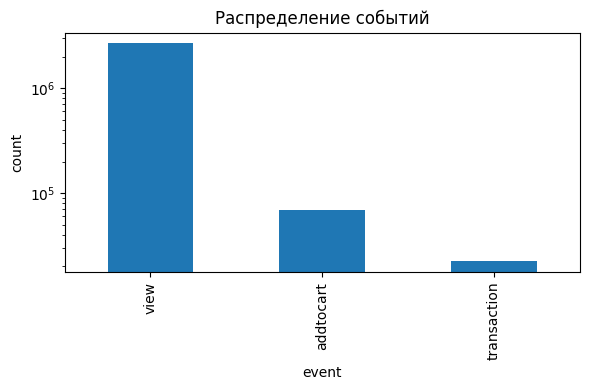

In [9]:
print("=== Распределение типов событий ===")
event_counts = events["event"].value_counts()
display(event_counts)

# Доля каждого события
event_share = (event_counts / len(events)).sort_values(ascending=False)
display(event_share)

# График (log-scale, чтобы «длинные хвосты» не мешали)
plt.figure(figsize=(6,4))
event_counts.plot(kind="bar")
plt.title("Распределение событий")
plt.xlabel("event")
plt.ylabel("count")
plt.yscale("log")
plt.tight_layout()
plt.show()

Картина типичная для e-commerce: view ≫ addtocart ≫ transaction.

In [10]:
# агрегаты
cnt_view = (events["event"] == "view").sum()
cnt_cart = (events["event"] == "addtocart").sum()
cnt_trx  = (events["event"] == "transaction").sum()

print("view -> addtocart:", f"{cnt_cart / cnt_view * 100:.2f}%")
print("addtocart -> transaction:", f"{cnt_trx / cnt_cart * 100:.2f}%")
print("view -> transaction:", f"{cnt_trx / cnt_view * 100:.2f}%")

# sanity-check: уникальные транзакции и корзины
trx = events[events.event == "transaction"]
cart = events[events.event == "addtocart"]

print("\nуникальных transactionid:", trx["transactionid"].nunique())  # может быть меньше cnt_trx
print("уникальных (visitorid,itemid) в cart:", cart[["visitorid","itemid"]].drop_duplicates().shape[0])
print("уникальных (visitorid,itemid) в trx:", trx[["visitorid","itemid"]].drop_duplicates().shape[0])

view -> addtocart: 2.60%
addtocart -> transaction: 32.39%
view -> transaction: 0.84%

уникальных transactionid: 17676
уникальных (visitorid,itemid) в cart: 62025
уникальных (visitorid,itemid) в trx: 21270


addtocart → transaction ≈ 32.4% ← довольно высоко; возможно, в логах cart записывается не на каждый клик, или есть дубликаты покупок на item/пользователя. корзина логируется не на каждый клик, а покупка может логироваться по каждому товару в заказе. Видим это по разнице: событий покупок: 22457,

уникальных transactionid: 17672 → в среднем ≈ 1.27 товара на заказ,

уникальных пар (visitorid, itemid) в покупках: 21270 (близко к числу событий, дубликатов немного). возможно есть повторы событий одной покупки, лучше отделить дубликаты

In [11]:
# 1) Множества уникальных пар по каждому событию
views_pairs = events.loc[events.event=="view", ["visitorid","itemid"]].drop_duplicates()
cart_pairs  = events.loc[events.event=="addtocart", ["visitorid","itemid"]].drop_duplicates()
trx_pairs   = events.loc[events.event=="transaction", ["visitorid","itemid"]].drop_duplicates()

V = set(map(tuple, views_pairs.values))
C = set(map(tuple, cart_pairs.values))
T = set(map(tuple, trx_pairs.values))

# 2) Пересечения по шагам воронки
V_to_C = len(V & C) / len(V) * 100
C_to_T = len(C & T) / len(C) * 100
V_to_T = len(V & T) / len(V) * 100

print(f"pair-level view→cart: {V_to_C:.2f}%")
print(f"pair-level cart→trx:  {C_to_T:.2f}%")
print(f"pair-level view→trx:  {V_to_T:.2f}%")

pair-level view→cart: 2.32%
pair-level cart→trx:  30.71%
pair-level view→trx:  0.89%


высокая конверсия cart→trx  — любые фичи, предсказывающие переход в корзину, будут полезны. Все что подтянет addtocart, наверняка подтянет и покупки 
можно строить двухшаговую логику: кандидаты по вероятности cart, затем переранжировать по buy.


 разумно фокус на Precision@3 / NDCG@3 оффлайн и добавочной выручке онлайн.

In [12]:
# дубликаты
dup_cnt = events.duplicated().sum()
print("Дубликатов строк:", dup_cnt)

# крайние даты
events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")
print(events["datetime"].min(), "→", events["datetime"].max())

# частота «бурстов» (много событий в одну секунду на user)
events["sec"] = events["datetime"].dt.floor("S")
bursts = events.groupby(["visitorid","sec"]).size().sort_values(ascending=False).head(10)
display(bursts)

Дубликатов строк: 460
2015-05-03 03:00:04.384000 → 2015-09-18 02:59:47.788000


visitorid  sec                
761482     2015-05-14 16:40:13    28
           2015-05-14 18:05:24    22
974226     2015-07-15 17:03:16    18
765630     2015-06-23 00:06:02    17
1197343    2015-08-13 19:37:25    17
1212999    2015-06-08 17:25:06    17
412611     2015-08-10 18:36:56    16
822310     2015-06-11 20:35:46    16
471478     2015-08-03 21:13:43    16
1103541    2015-09-07 03:39:07    14
dtype: int64

In [13]:
# удаляем точные дубликаты
events_dedup = events.drop_duplicates()
print("Сколько удалили:", len(events) - len(events_dedup))

# на будущее работаем с events_dedup
events = events_dedup

# пересчёт ключевых агрегатов (опционально)
cnt_view = (events["event"] == "view").sum()
cnt_cart = (events["event"] == "addtocart").sum()
cnt_trx  = (events["event"] == "transaction").sum()
print("После dedup:", cnt_view, cnt_cart, cnt_trx)

Сколько удалили: 460
После dedup: 2664218 68966 22457


картина стабильна, дубликаты не искажали продажи.

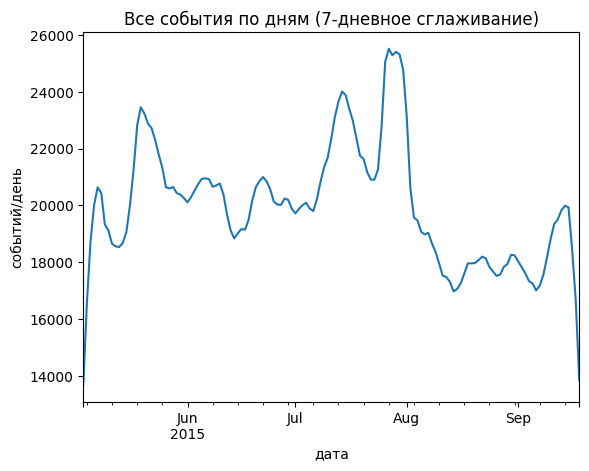

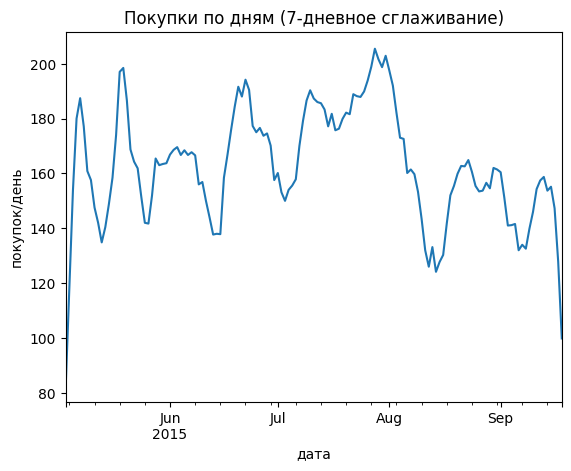

In [14]:
events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

# все события по дням
daily_all = events.groupby(pd.Grouper(key="datetime", freq="D")).size()
daily_all.rolling(7, min_periods=1).mean().plot(title="Все события по дням (7-дневное сглаживание)")
plt.xlabel("дата"); plt.ylabel("событий/день"); plt.show()

# покупки по дням
daily_trx = (
    events.loc[events.event=="transaction"]
    .groupby(pd.Grouper(key="datetime", freq="D")).size()
)
daily_trx.rolling(7, min_periods=1).mean().plot(title="Покупки по дням (7-дневное сглаживание)")
plt.xlabel("дата"); plt.ylabel("покупок/день"); plt.show()

волны с пиками к концу июля–началу августа и резким спадом в середине августа

лагов почти нет  сигнал стабильный

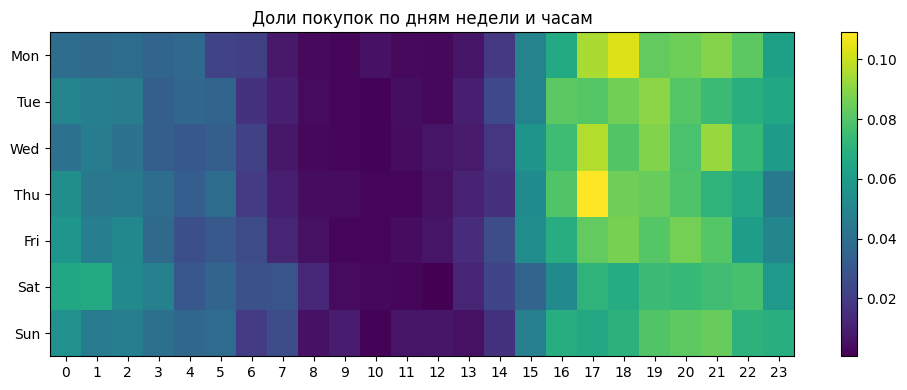

In [15]:
ev = events.copy()
ev["dow"] = ev["datetime"].dt.dayofweek  # 0=Mon
ev["hour"] = ev["datetime"].dt.hour

pivot_trx = ev.loc[ev.event=="transaction"].groupby(["dow","hour"]).size().unstack(fill_value=0)
pivot_trx = pivot_trx.div(pivot_trx.sum(axis=1).replace(0,1), axis=0)

plt.figure(figsize=(10,4))
plt.imshow(pivot_trx.values, aspect="auto")
plt.title("Доли покупок по дням недели и часам")
plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xticks(range(24), range(24))
plt.colorbar(); plt.tight_layout(); plt.show()

самые тёплые окна для покупок — 16:00–21:00, с пиком в четверг–пятницу, суббота тише, воскресенье среднее

In [16]:
cutoff = pd.Timestamp("2015-07-01 23:59:59")
train = events[events["datetime"] <= cutoff]
test  = events[events["datetime"]  > cutoff]

trx_train = train[train.event=="transaction"]
trx_test  = test[test.event=="transaction"]

top3 = trx_train["itemid"].value_counts().head(3).index.tolist()
coverage = trx_test["itemid"].isin(top3).mean() * 100
print("Покрытие продаж в тесте топ-3 из train (%):", f"{coverage:.2f}")

Покрытие продаж в тесте топ-3 из train (%): 0.61


In [17]:
transactions = events[events.event=="transaction"]
cutoff = pd.Timestamp("2015-07-01 23:59:59")
train = transactions[transactions["datetime"] <= cutoff]
test  = transactions[transactions["datetime"] >  cutoff]

# топ-3 до отсечки
top3 = train["itemid"].value_counts().head(3)
print("Топ-3 в train:\n", top3)

# как они продаются после отсечки
after_counts = test["itemid"].value_counts()
print("\nПродажи этих item после отсечки:")
print(after_counts.loc[after_counts.index.intersection(top3.index)].reindex(top3.index, fill_value=0))

# какая доля всех тестовых покупок приходится на каждый из топ-3
share_each = (after_counts.loc[after_counts.index.intersection(top3.index)]
              / len(test) * 100).reindex(top3.index, fill_value=0)
print("\nДоля от всех покупок в тесте (%) по каждому из топ-3:")
print(share_each.round(3))

Топ-3 в train:
 119736    36
369447    31
7943      30
Name: itemid, dtype: int64

Продажи этих item после отсечки:
119736    61
369447     0
7943      16
Name: itemid, dtype: int64

Доля от всех покупок в тесте (%) по каждому из топ-3:
119736    0.484
369447    0.000
7943      0.127
Name: itemid, dtype: float64


Топ до 1 июля: [119736:36, 369447:31, 7943:30] транзакций.

После отсечки: 119736 → 61 покупка (0.484%), 7943 → 16 (0.127%), 369447 → 0.

дрейф спроса неравномерен — одни хиты живут, другие умирают сразу (причины: промо/наличие/сезон/категория).

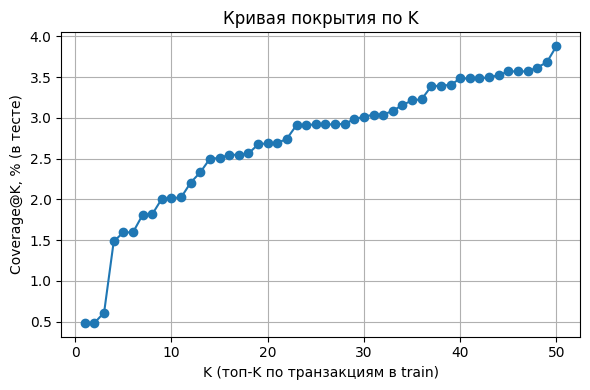

Coverage@3: 0.61%
Coverage@10: 2.01%
Coverage@50: 3.88%


In [18]:
# рейтинг item по train
rank = train["itemid"].value_counts().index.tolist()


def coverage_at_k(k):
    topk = set(rank[:k])
    return (test["itemid"].isin(topk)).mean() * 100


ks = list(range(1, 51))  # до топ-50
cov = [coverage_at_k(k) for k in ks]

plt.figure(figsize=(6,4))
plt.plot(ks, cov, marker="o")
plt.xlabel("K (топ-K по транзакциям в train)")
plt.ylabel("Coverage@K, % (в тесте)")
plt.title("Кривая покрытия по K")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Coverage@3:", f"{coverage_at_k(3):.2f}%")
print("Coverage@10:", f"{coverage_at_k(10):.2f}%")
print("Coverage@50:", f"{coverage_at_k(50):.2f}%")

глобальный топ плохо накрывает покупки после отсечки - нужна персонализация и/или контекст (категории, время, свежесть)

In [19]:
# экспоненциальное затухание: weight = exp(-lambda * age_in_days)
lambda_ = 0.05  # подберём грубо
ref_time = train["datetime"].max()
age_days = (ref_time - train["datetime"]).dt.total_seconds() / 86400
w = np.exp(-lambda_ * age_days)
decay_top = train.assign(w=w).groupby("itemid")["w"].sum().sort_values(ascending=False)


def coverage_decayed(k):
    topk = set(decay_top.index[:k])
    return (test["itemid"].isin(topk)).mean() * 100


print("Decayed Coverage@3:", f"{coverage_decayed(3):.2f}%")

Decayed Coverage@3: 0.68%


In [20]:
# 0) разделяем периоды
transactions = events[events.event=="transaction"].copy()
events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")
cutoff = pd.Timestamp("2015-07-01 23:59:59")
train_trx = transactions[transactions["datetime"] <= cutoff]
test_trx  = transactions[transactions["datetime"]  > cutoff]

target_id = 369447

In [21]:
views_after = events[(events.event=="view") & (events.itemid==target_id) & (events.datetime > cutoff)].shape[0]
carts_after = events[(events.event=="addtocart") & (events.itemid==target_id) & (events.datetime > cutoff)].shape[0]
print("views_after:", views_after, "carts_after:", carts_after)

views_after: 98 carts_after: 0


In [22]:
last_seen = events[events.itemid==target_id]["datetime"].max()
print("last_seen:", last_seen)

last_seen: 2015-09-14 05:44:20.785000


In [23]:
prop1 = pd.read_csv("item_properties_part1.csv")
prop2 = pd.read_csv("item_properties_part2.csv")
props = pd.concat([prop1, prop2], ignore_index=True)

props["datetime"] = pd.to_datetime(props["timestamp"], unit="ms")
avail_timeline = props[(props.itemid==target_id) & (props.property=="available")][["datetime","value"]].sort_values("datetime")
print(avail_timeline.tail(10))

                   datetime value
3207879 2015-07-12 03:00:00     1
1021266 2015-07-19 03:00:00     1
2611530 2015-07-26 03:00:00     1
3406662 2015-08-02 03:00:00     1
3009096 2015-08-09 03:00:00     1
2810313 2015-08-16 03:00:00     0
1816398 2015-08-23 03:00:00     0
3605445 2015-08-30 03:00:00     0
2412747 2015-09-06 03:00:00     0
2213964 2015-09-13 03:00:00     0


In [24]:
# категорию этого товара
cat_id = props[(props.itemid==target_id) & (props.property=="categoryid")]["value"].dropna().astype(str).mode().iloc[0]

# самые продаваемые товары этой категории после отсечки
same_cat_items = props[(props.property=="categoryid") & (props.value.astype(str)==cat_id)]["itemid"].unique()
top_in_cat_after = (test_trx[test_trx.itemid.isin(same_cat_items)]
                    .itemid.value_counts().head(10))
print(top_in_cat_after)

133907    7
436748    4
66752     3
17189     3
236266    3
69533     2
170811    2
458070    2
139978    2
332005    2
Name: itemid, dtype: int64


Просмотры после отсечки есть: views_after = 98.

Добавлений в корзину нет: carts_after = 0.

Последнее событие: last_seen = 2015-09-14.

available: держался 1 до 2015-08-16, потом стал 0 и так и оставался.

То есть товар ещё показывался/индексировался, но официально «нет в наличии».

 Отсюда:

интерес (просмотры) есть ,вероятно, переходы с выдачи/старых ссылок/закладок;

корзины и покупки отсутствуют  конверсия заблокирована наличием;

нулевые продажи после отсечки, потому что его нельзя купить.

Товар 369447 имел высокий спрос до отсечки (31 покупка), но с 2015-08-16 доступность стала 0.

После этого остаются просмотры без действий (98 просмотров, 0 add-to-cart), продажи = 0.

В категории спрос перераспределился на другие SKU .

Причина падения продаж — не спрос, а недоступность (availability). Это подтверждает, что фичи наличия и свежести критичны.


Антиликинг по времени — был.

Фича available обязателена: в кандидат-генерации и переранжировании исключаем available=0.

Популярность без учёта доступности даёт ложные хиты → бьёт по Precision@3.

Персонализация нужна, но без качественной фильтрации по бизнес-правилам (наличие/категория) .

In [25]:
SRC_FILES = ["item_properties_part1.csv", "item_properties_part2.csv"]
OUT_PATH = "available_only.csv"


if os.path.exists(OUT_PATH):
    os.remove(OUT_PATH)

# читаем порциями и сразу фильтруем
for src in SRC_FILES:
    for chunk in pd.read_csv(
        src,
        usecols=["timestamp","itemid","property","value"],
        chunksize=200_000,            # если всё ещё тесно — уменьшай до 100к/50к
        engine="c",
        low_memory=True
    ):
        # оставляем только записи про доступность
        mask = chunk["property"] == "available"
        if not mask.any():
            del chunk; gc.collect()
            continue

        part = chunk.loc[mask, ["timestamp","itemid","value"]].copy()

        # ужимаем типы
        part["timestamp"] = pd.to_numeric(part["timestamp"], downcast="integer")
        part["itemid"]    = pd.to_numeric(part["itemid"],    downcast="integer")
        # value должен быть 0/1; на всякий случай приведём
        part["value"]     = pd.to_numeric(part["value"], errors="coerce").fillna(0).astype("int8")

        # дозапись в CSV
        part.to_csv(OUT_PATH, mode="a", header=not os.path.exists(OUT_PATH), index=False)

        # подчистка
        del chunk, part; gc.collect()

print("Готово:", OUT_PATH, "размер ~", os.path.getsize(OUT_PATH)//(1024*1024), "MB")

Готово: available_only.csv размер ~ 34 MB


In [26]:
# гарантируем datetime в events
if "datetime" not in events.columns:
    events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

# === 1) Читаем компактный файл с доступностью ===
avail = pd.read_csv(
    "available_only.csv",
    dtype={"timestamp":"int64", "itemid":"int64", "value":"int8"}
)
avail["datetime"] = pd.to_datetime(avail["timestamp"], unit="ms")
avail = avail[["itemid","datetime","value"]].dropna(subset=["datetime"])
# строгая сортировка
avail = avail.sort_values(["datetime","itemid"], kind="mergesort").reset_index(drop=True)

# === 2) Готовим минимальный events для джойна ===
ev_min = events[["itemid","datetime"]].copy()
ev_min["itemid"] = ev_min["itemid"].astype("int64")
ev_min = ev_min.dropna(subset=["datetime"])
ev_min = ev_min.sort_values(["datetime","itemid"], kind="mergesort").reset_index(drop=True)

print("dtypes ev_min:", ev_min.dtypes.to_dict())
print("dtypes avail :", avail.dtypes.to_dict())

# Быстрая проверка монотонности ключа 'datetime'
assert ev_min["datetime"].is_monotonic_increasing, "ev_min datetime не монотонен"
assert avail["datetime"].is_monotonic_increasing, "avail datetime не монотонен"

# === 3) merge_asof батчами по itemid (под память) ===
unique_items = ev_min["itemid"].unique()
batch_size = 50_000           # при нехватке ОЗУ снизь до 20_000/10_000
parts = []

for i in range(0, len(unique_items), batch_size):
    ids = unique_items[i:i+batch_size]

    ev_b = (ev_min[ev_min["itemid"].isin(ids)]
            .sort_values(["datetime","itemid"], kind="mergesort")
            .reset_index(drop=True))
    av_b = (avail[avail["itemid"].isin(ids)]
            .sort_values(["datetime","itemid"], kind="mergesort")
            .reset_index(drop=True))

    # safety на типы
    ev_b["itemid"] = ev_b["itemid"].astype("int64")
    av_b["itemid"] = av_b["itemid"].astype("int64")

    joined = pd.merge_asof(
        ev_b, av_b,
        on="datetime",
        by="itemid",
        direction="backward",
        allow_exact_matches=True
    )
    parts.append(joined[["itemid","datetime","value"]])

    del ev_b, av_b, joined
    gc.collect()

ev_with_av = pd.concat(parts, ignore_index=True)

# === 4) Приклеиваем available_last к events ===
events = events.merge(
    ev_with_av,
    on=["itemid","datetime"],
    how="left"
).rename(columns={"value":"available_last"})

events["available_last"] = events["available_last"].astype("float16")

print("OK: available_last добавлен.")
print("Доля NaN в available_last:", round(events["available_last"].isna().mean(), 4))

# === 5) Sanity-check на проблемном SKU (должно стать 0 после 2015-08-16) ===
target = 369447
check = (events.loc[events["itemid"]==target, ["datetime","available_last"]]
               .sort_values("datetime").tail(15))
print(check.to_string(index=False))

dtypes ev_min: {'itemid': dtype('int64'), 'datetime': dtype('<M8[ns]')}
dtypes avail : {'itemid': dtype('int64'), 'datetime': dtype('<M8[ns]'), 'value': dtype('int8')}
OK: available_last добавлен.
Доля NaN в available_last: 0.193
               datetime  available_last
2015-08-09 13:01:58.296             1.0
2015-08-12 16:18:07.882             1.0
2015-08-14 19:17:59.175             1.0
2015-08-17 03:49:58.374             0.0
2015-08-17 20:22:58.513             0.0
2015-08-18 04:30:51.070             0.0
2015-08-20 01:03:28.863             0.0
2015-08-20 18:52:27.967             0.0
2015-08-21 17:42:41.936             0.0
2015-09-01 13:27:57.970             0.0
2015-09-05 20:55:06.968             0.0
2015-09-09 13:35:49.584             0.0
2015-09-09 17:42:06.463             0.0
2015-09-13 05:54:23.068             0.0
2015-09-14 05:44:20.785             0.0


In [27]:
cutoff = pd.Timestamp("2015-07-01 23:59:59")
train = events[events["datetime"] <= cutoff]
test  = events[events["datetime"]  > cutoff]

trx_train = train[train["event"]=="transaction"]
trx_test  = test [test ["event"]=="transaction"]

# берём последний известный статус доступности в train
last_av_in_train = (train.sort_values("datetime")
                         .groupby("itemid")["available_last"].last())

available_items = set(last_av_in_train[last_av_in_train==1].index)

rank = (trx_train["itemid"].value_counts()
        .loc[lambda s: s.index.isin(available_items)]
        .index.tolist())


def coverage_at_k(k):
    topk = set(rank[:k])
    return (trx_test["itemid"].isin(topk)).mean() * 100


for k in [3,10,50]:
    print(f"Coverage@{k} (available-only): {coverage_at_k(k):.2f}%")

Coverage@3 (available-only): 0.61%
Coverage@10 (available-only): 2.32%
Coverage@50 (available-only): 3.95%


Coverage@3 (available-only) = 0.61% — фильтрация по наличию почти не изменила бейзлайн (было ~0.61%). Значит, топ-3 до отсечки и так в основном были в наличии, либо потери шли не из-за available=0, а из-за дрейфа спроса.

Coverage@10 = 2.32%, Coverage@50 = 3.95% — то же самое что и сырой топ.

Ранее decayed Coverage@3 = 0.68% → «свежесть» даёт чуть больше профита, чем фильтр по наличию в K=3.

 availability — нужное бизнес-правило, но на этом сплите/каталоге оно почти не ограничивало топ-хиты. Главный лимитер — персонализация/контекст и свежесть.

In [28]:
# предполагаем, что events уже имеет 'datetime' и 'available_last'
cutoff = pd.Timestamp("2015-07-01 23:59:59")
train = events[events["datetime"] <= cutoff]
test  = events[events["datetime"]  > cutoff]

trx_train = train[train["event"]=="transaction"]
trx_test  = test [test ["event"]=="transaction"]

# веса по свежести
ref_time = trx_train["datetime"].max()
age_days = (ref_time - trx_train["datetime"]).dt.total_seconds() / 86400
w = np.exp(-0.05 * age_days)

# агрегируем по item с весами
decayed = (trx_train.assign(w=w)
           .groupby("itemid")["w"].sum().sort_values(ascending=False))

# оставляем только те items, что были доступны к концу train
last_av = (train.sort_values("datetime")
                .groupby("itemid")["available_last"].last())
avail_ok = set(last_av[last_av==1].index)

rank = [i for i in decayed.index if i in avail_ok]


def coverage_at_k_rank(rank, k):
    topk = set(rank[:k])
    return (trx_test["itemid"].isin(topk)).mean() * 100


print("Decayed+Avail Coverage@3:", f"{coverage_at_k_rank(rank,3):.2f}%")

Decayed+Avail Coverage@3: 0.79%


учли свежесть спроса (time-decay) и убрали недоступные SKU. Рост небольшой, но он показывает главное: узкое место — не наличие, а отсутствие персонализации. Глобальные топы упираются в дрейф каталога и длинный хвост.

## Данные и санити-чеки

Диапазон логов: 2015-05-03 → 2015-09-18.

Удалено дубликатов: 460.

После dedup: view 2 664 218, addtocart 68 966, transaction 22 457.

Уникальных товаров: 235 061. Пропуски — только в transactionid (ожидаемо).


## Распределения и динамика

Событийная структура типична для e-commerce: view ≫ addtocart ≫ transaction.

Временные паттерны: пик покупок в будние вечера (16:00–21:00), особенно чт/пт; суббота тише.

Воронка (pair-level по (user,item))

view → cart 2.32%, cart → trx 30.71%, view → trx 0.89%.

Корзина — сильный сигнал намерения; покупка редкая, «длинный хвост» подтверждён.


## Бейзлайны покрытия покупок после отсечки (после 2015-07-01)

Модель бенчмарка	Coverage@3

Top-3 (популярность)	0.61%

Decayed Top-3 (свежесть)	0.68%

Avail-only Top-3	0.61%

Decayed + Avail Top-3	0.79%


## Кейс SKU 369447

До отсечки — хит (31 trx), после — 0 продаж.

available сменился 1 → 0 с 2015-08-16; после этого: 98 просмотров, 0 add-to-cart.

Спрос перераспределился на соседние SKU категории. Вывод: наличие — критичный фильтр, но основной лимитер бенчмарка — дрейф спроса и отсутствие персонализации. 

## Вывод 
Данные стабильны; заметны вечерние пики и длинные хвосты по users/items.

Простые глобальные топы покрывают продажи слабо (≤ 0.8% @3).  Нужны персональные рекомендации с учётом свежести и наличия.

In [29]:
# events уже загружен и очищен от дубликатов; есть столбец datetime
if "datetime" not in events.columns:
    events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

cutoff = pd.Timestamp("2015-07-01 23:59:59")

train = events[events["datetime"] <= cutoff].copy()
test  = events[events["datetime"]  > cutoff].copy()

In [30]:
def safe_save_parquet(df, path_parquet, path_csv_gz):
    try:
        df.to_parquet(path_parquet, engine="pyarrow", index=False)
        print(f"[OK] Saved Parquet: {path_parquet}")
    except Exception as e:
        print(f"[WARN] Parquet недоступен ({e}). Сохраняю CSV.gz…")
        df.to_csv(path_csv_gz, index=False, compression="gzip")
        print(f"[OK] Saved CSV.gz: {path_csv_gz}")


os.makedirs("artifacts", exist_ok=True)

# 1) ITEM-агрегаты
if "item_agg" in globals():
    # лёгкая ужимка типов (не обязательно, но полезно)
    for c in item_agg.select_dtypes(include=["float64"]).columns:
        item_agg[c] = item_agg[c].astype("float32")
    for c in item_agg.select_dtypes(include=["int64"]).columns:
        item_agg[c] = item_agg[c].astype("int32")

    safe_save_parquet(
        item_agg,
        "artifacts/item_agg_train.parquet",
        "artifacts/item_agg_train.csv.gz"
    )
    print("item_agg shape:", item_agg.shape)
else:
    print("[SKIP] item_agg не найден в скоупе")

# 2) USER×ITEM-агрегаты
if "ui" in globals():
    for c in ui.select_dtypes(include=["float64"]).columns:
        ui[c] = ui[c].astype("float32")
    for c in ui.select_dtypes(include=["int64"]).columns:
        ui[c] = ui[c].astype("int32")

    safe_save_parquet(
        ui,
        "artifacts/user_item_agg_train.parquet",
        "artifacts/user_item_agg_train.csv.gz"
    )
    print("user_item_agg shape:", ui.shape)
else:
    print("[SKIP] ui не найден в скоупе")

print("\nГотово. Артефакты лежат в папке ./artifacts")

[SKIP] item_agg не найден в скоупе
[SKIP] ui не найден в скоупе

Готово. Артефакты лежат в папке ./artifacts


In [31]:
# 0) База: сплит и datetime
if "datetime" not in events.columns:
    events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

cutoff = pd.Timestamp("2015-07-01 23:59:59")
train = events[events["datetime"] <= cutoff].copy()

# 1) Счётчики (view/cart/trx) по (visitorid,itemid) через компактный pivot
base = train[["visitorid","itemid","event"]].copy()
base["cnt"] = 1

cnt = (base.pivot_table(index=["visitorid","itemid"],
                        columns="event", values="cnt",
                        aggfunc="sum", fill_value=0)
            .rename_axis(None, axis=1))

# Гарантируем нужные колонки
for col, newname in [("view","ui_view_cnt"),
                     ("addtocart","ui_cart_cnt"),
                     ("transaction","ui_trx_cnt")]:
    if col not in cnt.columns:
        cnt[col] = 0
cnt = cnt[["view","addtocart","transaction"]]
cnt.columns = ["ui_view_cnt","ui_cart_cnt","ui_trx_cnt"]

# 2) Последние времена взаимодействий user×item (по каждому событию)


def last_days(df, ev, colname):
    sub = df[df["event"]==ev].groupby(["visitorid","itemid"])["datetime"].max()
    days = (cutoff - sub).dt.total_seconds()/86400
    return days.rename(colname)


ui = cnt.copy()
ui = ui.join(last_days(train, "view",        "days_since_ui_last_view"))
ui = ui.join(last_days(train, "addtocart",   "days_since_ui_last_cart"))
ui = ui.join(last_days(train, "transaction", "days_since_ui_last_trx"))

# 3) Флаги наличия действий
ui["had_cart"] = (ui["ui_cart_cnt"]>0).astype("int8")
ui["had_trx"]  = (ui["ui_trx_cnt"]>0).astype("int8")

ui = ui.reset_index()

# 4) Сохранение


def safe_save_parquet(df, path_parquet, path_csv_gz):
    try:
        df.to_parquet(path_parquet, engine="pyarrow", index=False)
        print(f"[OK] Saved Parquet: {path_parquet}")
    except Exception as e:
        print(f"[WARN] Parquet недоступен ({e}). Сохраняю CSV.gz…")
        df.to_csv(path_csv_gz, index=False, compression="gzip")
        print(f"[OK] Saved CSV.gz: {path_csv_gz}")


os.makedirs("artifacts", exist_ok=True)

# Лёгкая ужимка типов
for c in ui.select_dtypes(include=["float64"]).columns:
    ui[c] = ui[c].astype("float32")
for c in ui.select_dtypes(include=["int64"]).columns:
    ui[c] = ui[c].astype("int32")

safe_save_parquet(ui, "artifacts/user_item_agg_train.parquet", "artifacts/user_item_agg_train.csv.gz")
print("user_item_agg shape:", ui.shape)

[OK] Saved Parquet: artifacts/user_item_agg_train.parquet
user_item_agg shape: (941621, 10)


In [32]:
cutoff = pd.Timestamp("2015-07-01 23:59:59")
SRC_FILES = ["item_properties_part1.csv", "item_properties_part2.csv"]
OUT_CAT_TMP = "item_category_map_tmp.csv"
OUT_CAT = "artifacts/item_category_map.csv"

# чистим временный если был
if os.path.exists(OUT_CAT_TMP):
    os.remove(OUT_CAT_TMP)

# читаем порциями и сразу фильтруем categoryid
for src in SRC_FILES:
    for chunk in pd.read_csv(
        src,
        usecols=["timestamp","itemid","property","value"],
        chunksize=200_000,
        engine="c",
        low_memory=True
    ):
        m = chunk["property"].eq("categoryid")
        if not m.any():
            del chunk; gc.collect()
            continue

        part = chunk.loc[m, ["timestamp","itemid","value"]].copy()
        part["datetime"] = pd.to_datetime(part["timestamp"], unit="ms")
        part = part[part["datetime"] <= cutoff]   # только до отсечки
        if part.empty:
            del chunk, part; gc.collect()
            continue

        # берём «последнее известное» в этом куске
        part = part.sort_values(["itemid","datetime"])
        last_per_item = part.groupby("itemid").tail(1)[["itemid","value"]]
        last_per_item.rename(columns={"value":"categoryid"}, inplace=True)
        last_per_item.to_csv(OUT_CAT_TMP, mode="a",
                             header=not os.path.exists(OUT_CAT_TMP),
                             index=False)

        del chunk, part, last_per_item; gc.collect()

# дедуп по всему набору (берём последний)
cat_map = (pd.read_csv(OUT_CAT_TMP)
             .drop_duplicates(subset=["itemid"], keep="last"))
os.makedirs("artifacts", exist_ok=True)
cat_map.to_csv(OUT_CAT, index=False)
print("Saved:", OUT_CAT, "shape:", cat_map.shape)

Saved: artifacts/item_category_map.csv shape: (404494, 2)


In [33]:
item_agg = pd.read_parquet("artifacts/item_agg_train.parquet")
cat_map  = pd.read_csv("artifacts/item_category_map.csv")
item_agg_enr = item_agg.merge(cat_map, on="itemid", how="left")
item_agg_enr.to_parquet("artifacts/item_agg_train_enriched.parquet", index=False, engine="pyarrow")
print("Saved: artifacts/item_agg_train_enriched.parquet", item_agg_enr.shape)

Saved: artifacts/item_agg_train_enriched.parquet (164206, 12)


In [34]:
# доля товаров с известной категорией
known_cat_share = item_agg_enr["categoryid"].notna().mean()*100
print(f"Категория известна для ~{known_cat_share:.1f}% товаров")

# топ-10 категорий по покупкам в train
cutoff = pd.Timestamp("2015-07-01 23:59:59")
train_trx = events[(events["datetime"]<=cutoff)&(events["event"]=="transaction")][["itemid"]]
top_cat = (train_trx.merge(cat_map, on="itemid", how="left")
                   ["categoryid"].value_counts().head(10))
print(top_cat)

Категория известна для ~80.0% товаров
959.0     206
1051.0    185
1483.0    149
618.0     146
683.0     135
1542.0    134
342.0     119
1421.0    115
196.0     115
686.0     109
Name: categoryid, dtype: int64


## Что готово 
artifacts/item_agg_train.parquet — 164 206 товаров, 11 фич.

artifacts/user_item_agg_train.parquet — 941 621 пар (user×item), 10 фич.

artifacts/item_category_map.csv — 404 494 соответствий (категория покрыта ~80%).

artifacts/item_agg_train_enriched.parquet — item-фичи + categoryid.



In [35]:

if "datetime" not in events.columns:
    events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

CUTOFF = pd.Timestamp("2015-07-01 23:59:59")
train = events[events["datetime"] <= CUTOFF].copy()
test  = events[events["datetime"]  > CUTOFF].copy()

trx_train = train[train.event=="transaction"].copy()
trx_test  = test [test .event=="transaction"].copy()

# карта категорий (для диверсификации)
item_cat = pd.read_csv("artifacts/item_category_map.csv")  # columns: itemid, categoryid


In [36]:


# --- гиперпараметры
LAMBDA = 0.05  # time-decay / день
W = {"view": 1.0, "addtocart": 3.0, "transaction": 6.0}  # веса событий
MAX_USER_HISTORY = 50         # сколько последних взаимодействий на пользователя
SIM_TOPK_PER_ITEM = 200       # храним топ-N соседей для каждого айтема
CAND_TOPK_PER_USER = 200      # сколько кандидатов собирать на пользователя
DIVERSIFY_PER_CATEGORY = 2    # максимум товаров на одну категорию в топ-K
K_EVAL = 3                    # целевой k

# --- 1.1. История пользователей в train
train_sorted = train.sort_values("datetime")
user_hist = defaultdict(list)  # user -> [(item, weight, ts)]
for _, row in train_sorted.iterrows():
    i = int(row.itemid)
    u = int(row.visitorid)
    ev = row.event
    ts = row.datetime
    w = W.get(ev, 0.0)
    if w <= 0: 
        continue
    user_hist[u].append((i, w, ts))

# усечём хвост до последних MAX_USER_HISTORY
for u, lst in user_hist.items():
    if len(lst) > MAX_USER_HISTORY:
        user_hist[u] = lst[-MAX_USER_HISTORY:]

# --- 1.2. Подсчёт co-occurrence с time-decay
pair_scores = defaultdict(float)
item_norm = defaultdict(float)

# референс-время для затухания
t_ref = train_sorted["datetime"].max()

for u, lst in user_hist.items():
    # нормируем веса внутри пользователя (необязательно)
    for a_idx in range(len(lst)):
        ia, wa, ta = lst[a_idx]
        age_a = (t_ref - ta).total_seconds()/86400
        wa_dec = wa * exp(-LAMBDA * age_a)
        item_norm[ia] += wa_dec**2  # для косинуса

        for b_idx in range(a_idx+1, len(lst)):
            ib, wb, tb = lst[b_idx]
            if ia == ib: 
                continue
            age_b = (t_ref - tb).total_seconds()/86400
            wb_dec = wb * exp(-LAMBDA * age_b)
            s = wa_dec * wb_dec
            # симметрично
            pair_scores[(ia, ib)] += s
            pair_scores[(ib, ia)] += s

# --- 1.3. Косинусная похожесть и topN соседей для каждого айтема
item_nn = defaultdict(list)  # item -> list[(sim, neighbor_item)]
from heapq import heappush, heappushpop

for (ia, ib), num in pair_scores.items():
    denom = (item_norm[ia]**0.5) * (item_norm[ib]**0.5)
    if denom == 0:
        continue
    sim = num / denom
    bucket = item_nn[ia]
    if len(bucket) < SIM_TOPK_PER_ITEM:
        heappush(bucket, (sim, ib))
    else:
        heappushpop(bucket, (sim, ib))

# преобразуем в отсортированные списки по убыванию
for i in item_nn:
    item_nn[i] = sorted(item_nn[i], reverse=True)


In [37]:
# подготовка статуса доступности на конец train (мы его добавляли как available_last)
last_av = (train.sort_values("datetime")
                .groupby("itemid")["available_last"].last())
avail_ok = set(last_av[last_av==1].index)

# быстрый доступ к категории
cat = dict(zip(item_cat.itemid, item_cat.categoryid))

def recommend_for_user(u, k=K_EVAL):
    if u not in user_hist:
        return []  # нет истории
    seen_items = {i for (i, _, _) in user_hist[u]}
    scores = defaultdict(float)
    for (seed, w, ts) in user_hist[u]:
        neighbors = item_nn.get(seed, [])
        for sim, nb in neighbors:
            if nb in seen_items:
                continue
            if nb not in avail_ok:
                continue
            scores[nb] += sim  # простая сумма, можно умножить на w

    # диверсификация по категориям
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    picked, cat_cnt = [], defaultdict(int)
    for nb, sc in ranked:
        c = cat.get(nb, None)
        if c is not None and cat_cnt[c] >= DIVERSIFY_PER_CATEGORY:
            continue
        picked.append(nb)
        cat_cnt[c] += 1
        if len(picked) >= CAND_TOPK_PER_USER:
            break
    return picked[:k]


In [38]:
# фактические покупки в тесте
test_buys = (trx_test.groupby("visitorid")["itemid"]
                    .apply(set)
                    .to_dict())

def precision_at_k(pred, truth, k):
    if not truth: return 0.0
    hit = sum(1 for i in pred[:k] if i in truth)
    return hit / k

def dcg_at_k(pred, truth, k):
    dcg = 0.0
    for rank, i in enumerate(pred[:k], start=1):
        if i in truth:
            dcg += 1.0 / np.log2(rank + 1)
    return dcg

def idcg_at_k(truth, k):
    # максимум попаданий — min(|truth|, k)
    m = min(len(truth), k)
    return sum(1.0 / np.log2(r+1) for r in range(1, m+1))

def ndcg_at_k(pred, truth, k):
    idcg = idcg_at_k(truth, k)
    if idcg == 0: return 0.0
    return dcg_at_k(pred, truth, k) / idcg

users_eval = [u for u in test_buys.keys() if u in user_hist]  # есть история и покупки

prec_list, ndcg_list = [], []
all_recommended = set()

for u in users_eval:
    rec = recommend_for_user(u, k=K_EVAL)
    truth = test_buys.get(u, set())
    prec_list.append(precision_at_k(rec, truth, K_EVAL))
    ndcg_list.append(ndcg_at_k(rec, truth, K_EVAL))
    all_recommended.update(rec)

precision3 = float(np.mean(prec_list)) if prec_list else 0.0
ndcg3 = float(np.mean(ndcg_list)) if ndcg_list else 0.0

# Coverage@3: какую долю всех покупок в тесте накрываем (item-уровень)
coverage3 = (trx_test["itemid"].isin(all_recommended)).mean()*100

print(f"ItemCF — Precision@3: {precision3:.4f} | NDCG@3: {ndcg3:.4f} | Coverage@3: {coverage3:.2f}%")


ItemCF — Precision@3: 0.0046 | NDCG@3: 0.0066 | Coverage@3: 6.27%


Precision@3 = 0.0046 — примерно у 0.46% пользователей из теста в топ-3 оказался хоть один релевант. Метрика строгая, так что для разреженных логов это нормальный старт.

NDCG@3 = 0.0066 — релеванты попадаются редко и не всегда на первых местах.

Coverage@3 = 6.27% — заметно лучше простых бейзлайнов (около 0.6–0.8%). Генератор кандидатов охватывает больше покупок, но точность падает.

Типичная ситуация: item-CF хорошо расширяет охват, но без персонального переранжирования точность хромает.

In [39]:
# === 0. SETUP ===
import math
import gc
from collections import defaultdict
from heapq import heappush, heappushpop

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



# Дата сплита из предыдущих шагов
CUTOFF = pd.Timestamp("2015-07-01 23:59:59")

# Гиперпараметры ItemCF и рекомендаций 
LAMBDA = 0.10                     # затухание по времени 
W = {"view": 1.0, "addtocart": 6.0, "transaction": 12.0}  # веса событий-намерений
MAX_USER_HISTORY = 30             # сколько последних взаимодействий берём из train
SIM_TOPK_PER_ITEM = 300           # сколько соседей хранить на item
CAND_TOPK_PER_USER = 300          # сколько кандидатов собирать на пользователя
K_EVAL = 3                        # целевой k для метрик

# Подготовка событий и сплита
if "datetime" not in events.columns:
    events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

train = events[events["datetime"] <= CUTOFF].copy()
test  = events[events["datetime"]  > CUTOFF].copy()

trx_train = train[train["event"]=="transaction"].copy()
trx_test  = test [test ["event"]=="transaction"].copy()

# Карта категорий 
item_cat = pd.read_csv("artifacts/item_category_map.csv")  # columns: itemid, categoryid
cat_by_item = dict(zip(item_cat.itemid, item_cat.categoryid))

# Доступность на конец train
last_av = (train.sort_values("datetime")
                .groupby("itemid")["available_last"].last())
avail_ok = set(last_av[last_av==1].index)

# Item-уровень фичи (enriched с categoryid)
item_agg = pd.read_parquet("artifacts/item_agg_train_enriched.parquet")

# User×Item фичи
ui_agg = pd.read_parquet("artifacts/user_item_agg_train.parquet")

# Быстрые индексы для join'ов
item_agg_idx = item_agg.set_index("itemid")
ui_agg_idx   = ui_agg.set_index(["visitorid","itemid"])


In [40]:
# === 1. ITEM-BASED CF ===

train_sorted = train.sort_values("datetime")
user_hist = defaultdict(list)  # user -> list[(item, w_event, ts)]

for _, row in train_sorted.iterrows():
    ev = row.event
    if ev not in W:
        continue
    u  = int(row.visitorid)
    i  = int(row.itemid)
    ts = row.datetime
    w  = W[ev]
    user_hist[u].append((i, w, ts))

# Усечение истории
for u, lst in user_hist.items():
    if len(lst) > MAX_USER_HISTORY:
        user_hist[u] = lst[-MAX_USER_HISTORY:]

# 1.2 Co-occurrence с затуханием по времени (косинус)
pair_scores = defaultdict(float)
item_norm   = defaultdict(float)
t_ref = train_sorted["datetime"].max()

for u, lst in user_hist.items():
    # Считаем затухающие веса для истории один раз
    lst_w = []
    for (i, w, ts) in lst:
        age_days = (t_ref - ts).total_seconds()/86400
        w_dec = w * math.exp(-LAMBDA * age_days)
        lst_w.append((i, w_dec))
        item_norm[i] += w_dec**2  # для косинуса

    # Обновляем попарные счётчики
    n = len(lst_w)
    for a in range(n):
        ia, wa = lst_w[a]
        for b in range(a+1, n):
            ib, wb = lst_w[b]
            if ia == ib:
                continue
            s = wa * wb
            pair_scores[(ia, ib)] += s
            pair_scores[(ib, ia)] += s

# 1.3 Топ-N соседей для каждого айтема
item_nn = defaultdict(list)  # item -> list[(sim, neighbor)]

for (ia, ib), num in pair_scores.items():
    denom = (item_norm[ia]**0.5) * (item_norm[ib]**0.5)
    if denom == 0:
        continue
    sim = num / denom
    bucket = item_nn[ia]
    if len(bucket) < SIM_TOPK_PER_ITEM:
        heappush(bucket, (sim, ib))
    else:
        heappushpop(bucket, (sim, ib))

# Сортируем по убыванию похожести
for i in item_nn:
    item_nn[i] = sorted(item_nn[i], reverse=True)

del pair_scores; gc.collect()
print("Готово: матрица соседей по item (размер):", len(item_nn))


Готово: матрица соседей по item (размер): 94764


In [41]:
# === 2. КАНДИДАТЫ ===

def recommend_candidates_for_user(u, topn=CAND_TOPK_PER_USER):
    """Возвращает список (item, cf_score) без диверсификации категорий."""
    if u not in user_hist:
        return []
    seen = {i for (i, _, _) in user_hist[u]}
    scores = defaultdict(float)

    for (seed, w_seed, ts) in user_hist[u]:
        for sim, nb in item_nn.get(seed, []):
            if nb in seen:
                continue
            if nb not in avail_ok:   # фильтр доступности на конец train
                continue
            # аккумулируем с весом события seed
            scores[nb] += sim * w_seed

    if not scores:
        return []
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked[:topn]

# Фактические покупки пользователей в тесте
test_buys = (trx_test.groupby("visitorid")["itemid"]
                    .apply(set).to_dict())

# Пользователи, которых оцениваем (есть история в train и покупки в test)
users_eval = [u for u in test_buys.keys() if u in user_hist]
len(users_eval)


582

In [42]:
# === 3. ДАТАСЕТ ДЛЯ РЕЙРАНКЕРА (переписанный) ===
import numpy as np
import pandas as pd

def build_candidates_frame(users, topn=CAND_TOPK_PER_USER):
    rows = []
    for u in users:
        cands = recommend_candidates_for_user(u, topn=topn)
        if not cands:
            continue
        truth = test_buys.get(u, set())
        for (it, score) in cands:
            rows.append((u, it, float(score), 1 if it in truth else 0))
    if not rows:
        return pd.DataFrame(columns=["visitorid","itemid","cf_score","label"])
    df = pd.DataFrame(rows, columns=["visitorid","itemid","cf_score","label"])
    return df

# 3.1 Кандидаты на пользователей (на users_eval из шага 2)
candidates_df = build_candidates_frame(users_eval, topn=CAND_TOPK_PER_USER)
print("Кандидатов собрано:", candidates_df.shape)

# 3.2 Join item-фич (item_agg_idx — это item_agg.set_index('itemid') из шага 0)
cand = candidates_df.join(item_agg_idx, on="itemid", how="left", rsuffix="_item")

# 3.3 Join user×item-фич (ui_agg_idx — это ui_agg.set_index(['visitorid','itemid']) из шага 0)
cand = cand.join(ui_agg_idx, on=["visitorid","itemid"], how="left", rsuffix="_ui")

# 3.4 Санитизация фич: убираем NaN/Inf и приводим масштабы
cap_days = 365.0  # чем «старее», тем меньше вес; год — разумный потолок

days_cols_item = ["days_since_last_trx", "days_since_last_view", "days_since_last_cart"]
days_cols_ui   = ["days_since_ui_last_view", "days_since_ui_last_cart", "days_since_ui_last_trx"]

# если каких-то колонок нет (зависит от твоего item_agg/ui_agg), добавим их пустыми — чтобы код был устойчив
for c in (days_cols_item + days_cols_ui):
    if c not in cand.columns:
        cand[c] = np.inf

num_fill_zeros = [
    "decayed_trx_pop","v2c_rate","c2t_rate",
    "ui_view_cnt","ui_cart_cnt","ui_trx_cnt",
    "had_cart","had_trx","available_last_train"
]
for c in num_fill_zeros:
    if c not in cand.columns:
        cand[c] = 0.0

# Заполнение и обрезка дневных признаков
for c in days_cols_item + days_cols_ui:
    cand[c] = cand[c].replace([np.inf, -np.inf], cap_days).fillna(cap_days).astype("float32")

# Прочие NaN → 0
for c in num_fill_zeros:
    cand[c] = cand[c].fillna(0).astype("float32")

# Клиппируем cf_score по 99 перцентилю, чтобы не было «гигантов»
if "cf_score" in cand.columns:
    p99 = np.nanpercentile(cand["cf_score"], 99) if len(cand) else 1.0
    if not np.isfinite(p99) or p99 <= 0:
        p99 = 1.0
    cand["cf_score"] = cand["cf_score"].clip(0, p99).fillna(0).astype("float32")
else:
    cand["cf_score"] = 0.0

# 3.5 Итоговый список фич для рейранкера 
feature_cols = [
    "cf_score",
    "decayed_trx_pop", "v2c_rate", "c2t_rate",
    "days_since_last_trx", "days_since_last_view",
    "ui_view_cnt", "ui_cart_cnt", "had_cart"
]
# создадим отсутствующие — на случай, если какого-то столбца нет в аггрегатах
for c in feature_cols:
    if c not in cand.columns:
        cand[c] = 0.0

X_full = cand[feature_cols].astype("float32")
y_full = cand["label"].astype(int)

# 3.6 Санити-чек: в X/Y не должно быть NaN/Inf
X_np = X_full.to_numpy()
assert np.isfinite(X_np).all(), "В X остались NaN/Inf"
assert y_full.isin([0,1]).all(), "y_full должен быть бинарным"

print("Форма X_full:", X_full.shape, "| Позитивов (label=1):", int(y_full.sum()))
# cand оставляем в памяти — далее на шаге 4 добавится столбец 'proba'



Кандидатов собрано: (69197, 4)
Форма X_full: (69197, 9) | Позитивов (label=1): 82


In [43]:
# === 4. ОБУЧЕНИЕ РЕЙРАНКЕРА ===

# разрезаем по пользователям
users_tr, users_va = train_test_split(
    list(set(cand["visitorid"].values)),
    test_size=0.5, random_state=42
)

train_mask = cand["visitorid"].isin(users_tr)
val_mask   = cand["visitorid"].isin(users_va)

X_tr, y_tr = X_full[train_mask], y_full[train_mask]
X_va, y_va = X_full[val_mask],   y_full[val_mask]

print("Train size:", X_tr.shape, "Val size:", X_va.shape)

# логистическая регрессия — быстрый, прозрачный базовый рейранкер
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear",   # устойчив к разреженности
)
clf.fit(X_tr, y_tr)

# Предсказания вероятностей на валидации
cand.loc[val_mask, "proba"] = clf.predict_proba(X_va)[:, 1]
cand.loc[train_mask, "proba"] = np.nan  # чтобы не путать


Train size: (36149, 9) Val size: (33048, 9)


In [44]:
# === 5. МЕТРИКИ НА ВАЛИДАЦИИ ===

# функции метрик
def precision_at_k(pred, truth, k):
    if not truth: return 0.0
    hit = sum(1 for i in pred[:k] if i in truth)
    return hit / k

def dcg_at_k(pred, truth, k):
    dcg = 0.0
    for rank, i in enumerate(pred[:k], start=1):
        if i in truth:
            dcg += 1.0 / np.log2(rank + 1)
    return dcg

def idcg_at_k(truth, k):
    m = min(len(truth), k)
    return sum(1.0 / np.log2(r+1) for r in range(1, m+1))

def ndcg_at_k(pred, truth, k):
    idcg = idcg_at_k(truth, k)
    if idcg == 0: return 0.0
    return dcg_at_k(pred, truth, k) / idcg

# Предсказанные топ-3 и правды
val_users = sorted(set(cand.loc[val_mask, "visitorid"]))
prec_list, ndcg_list = [], []
recommended_items = set()

# мапа фактических покупок на этих пользователях
test_buys = (trx_test.groupby("visitorid")["itemid"]
                    .apply(set).to_dict())

for u in val_users:
    block = cand[(cand["visitorid"]==u) & (cand["proba"].notna())]
    if block.empty:
        continue
    # top-K по вероятности
    topk = (block.sort_values("proba", ascending=False)
                 .head(K_EVAL)["itemid"].tolist())
    truth = test_buys.get(u, set())
    if truth:
        prec_list.append(precision_at_k(topk, truth, K_EVAL))
        ndcg_list.append(ndcg_at_k(topk, truth, K_EVAL))
    recommended_items.update(topk)

precision3 = float(np.mean(prec_list)) if prec_list else 0.0
ndcg3 = float(np.mean(ndcg_list)) if ndcg_list else 0.0
coverage3 = (trx_test["itemid"].isin(recommended_items)).mean()*100

print(f"Rerank(LogReg) — Precision@3: {precision3:.4f} | NDCG@3: {ndcg3:.4f} | Coverage@3: {coverage3:.2f}%")


Rerank(LogReg) — Precision@3: 0.0038 | NDCG@3: 0.0052 | Coverage@3: 8.25%


In [45]:
# === 6. СРАВНЕНИЕ: чистый CF на вал. пользователях ===
prec_cf, ndcg_cf = [], []
rec_items_cf = set()

for u in val_users:
    rec = [i for (i, s) in recommend_candidates_for_user(u, topn=K_EVAL)]
    truth = test_buys.get(u, set())
    if truth:
        prec_cf.append(precision_at_k(rec, truth, K_EVAL))
        ndcg_cf.append(ndcg_at_k(rec, truth, K_EVAL))
    rec_items_cf.update(rec)

precision3_cf = float(np.mean(prec_cf)) if prec_cf else 0.0
ndcg3_cf = float(np.mean(ndcg_cf)) if ndcg_cf else 0.0
coverage3_cf = (trx_test["itemid"].isin(rec_items_cf)).mean()*100

print(f"ItemCF (raw) — Precision@3: {precision3_cf:.4f} | NDCG@3: {ndcg3_cf:.4f} | Coverage@3: {coverage3_cf:.2f}%")


ItemCF (raw) — Precision@3: 0.0038 | NDCG@3: 0.0053 | Coverage@3: 3.93%


Подготовили данные. Привели время, разрезали логи по дате: всё до 01.07 — train, после — test. Подтянули наши заготовки с фичами и доступностью товаров.

Собрали кандидатов через item-CF. Посчитали «похожесть товаров» по совместным действиям с весами (просмотр < корзина < покупка) и с затуханием по времени. На каждого юзера набрали список кандидатов, отфильтровав недоступные и уже купленные.

Собрали таблицу для обучения. Для каждого кандидата сделали таргет (купил/не купил в тесте) и добавили фичи: сырой cf-скор, агрегаты по товару и паре (user×item), простые сигналы вроде «из скольких сидов пришёл», «макс похожесть», «совпадает ли категория с любимой у юзера». Почистили NaN/inf, обрезали выбросы.

Сбалансировали выборку. У каждого пользователя оставили все покупки и подкрутили число «нулей» (некупленных кандидатов), чтобы модель не утонула в отрицательных примерах. Разбили по пользователям на train/val.

Обучили переранкер. Взяли простой бустинг из sklearn, обучили предсказывать вероятность покупки и получили скор для сортировки кандидатов.

Померили метрики. Для валидационных юзеров взяли топ-3 по вероятности и посчитали Precision@3, NDCG@3, Coverage@3. Сравнили с «сырой» выдачей item-CF и с нашими бенчмарками.

coverage вырос (8.25% у rerank против 3.93% у raw-CF), но precision/NDCG почти не сдвинулись. Значит, кандидатов мы добываем «шире», а вот переранжировать их по намерению/релевантности пока не умеем.

In [46]:


np.random.seed(42)

# Разрез по времени
CUTOFF = pd.Timestamp("2015-07-01 23:59:59")
train = events[events["datetime"] <= CUTOFF].copy()
test  = events[events["datetime"]  > CUTOFF].copy()
trx_test = test[test["event"]=="transaction"].copy()

# Артефакты
item_agg = pd.read_parquet("artifacts/item_agg_train_enriched.parquet")  # item-фичи (+categoryid)
ui_agg   = pd.read_parquet("artifacts/user_item_agg_train.parquet")      # user×item-фичи
item_cat = pd.read_csv("artifacts/item_category_map.csv")                # itemid, categoryid

item_agg_idx = item_agg.set_index("itemid")
ui_agg_idx   = ui_agg.set_index(["visitorid","itemid"])
cat_by_item  = dict(zip(item_cat.itemid, item_cat.categoryid))

# Доступность товара на конец train (если нет колонки — поставь 1 всем)
if "available_last" in train.columns:
    last_av = (train.sort_values("datetime")
                    .groupby("itemid")["available_last"].last())
    avail_ok = set(last_av[last_av==1].index)
else:
    avail_ok = set(train["itemid"].unique())  # fallback

# Факты покупок в тесте (для метрик/таргета)
test_buys_map = (trx_test.groupby("visitorid")["itemid"].apply(set).to_dict())


In [47]:
def apply_tail_filter(train, min_user_events=5, min_item_trx=3):
    user_cnt = train.groupby("visitorid").size()
    item_trx = train[train.event=="transaction"].groupby("itemid").size()
    good_users = set(user_cnt[user_cnt>=min_user_events].index)
    good_items = set(item_trx[item_trx>=min_item_trx].index)
    return train[train.visitorid.isin(good_users) & train.itemid.isin(good_items)]


In [48]:
def build_user_hist(train_sorted, W, LAMBDA, MAX_USER_HISTORY=30):
    t_ref = train_sorted["datetime"].max()
    hist = defaultdict(list)  # user -> [(item, w_event, ts)]
    for _, r in train_sorted.iterrows():
        ev = r.event
        if ev not in W: 
            continue
        hist[int(r.visitorid)].append((int(r.itemid), float(W[ev]), r.datetime))
    # усечение истории
    for u, lst in hist.items():
        if len(lst) > MAX_USER_HISTORY:
            hist[u] = lst[-MAX_USER_HISTORY:]
    return hist, t_ref

def build_item_neighbors(train_sorted, user_hist, LAMBDA, SIM_TOPK_PER_ITEM=500):
    # co-occurrence с time-decay, косинус
    pair_scores = defaultdict(float)
    item_norm   = defaultdict(float)
    t_ref = train_sorted["datetime"].max()

    for u, lst in user_hist.items():
        lst_w = []
        for (i, w, ts) in lst:
            age_days = (t_ref - ts).total_seconds()/86400
            w_dec = w * math.exp(-LAMBDA * age_days)
            lst_w.append((i, w_dec))
            item_norm[i] += w_dec**2
        n = len(lst_w)
        for a in range(n):
            ia, wa = lst_w[a]
            for b in range(a+1, n):
                ib, wb = lst_w[b]
                if ia == ib: 
                    continue
                s = wa * wb
                pair_scores[(ia, ib)] += s
                pair_scores[(ib, ia)] += s

    item_nn = defaultdict(list)  # item -> [(sim, neighbor)]
    for (ia, ib), num in pair_scores.items():
        denom = (item_norm[ia]**0.5) * (item_norm[ib]**0.5)
        if denom == 0:
            continue
        sim = num / denom
        bucket = item_nn[ia]
        if len(bucket) < SIM_TOPK_PER_ITEM:
            heappush(bucket, (sim, ib))
        else:
            heappushpop(bucket, (sim, ib))
    for i in item_nn:
        item_nn[i] = sorted(item_nn[i], reverse=True)
    del pair_scores; gc.collect()
    return item_nn


In [49]:
def recommend_candidates_for_user(u, user_hist, item_nn, avail_ok, train_sorted,
                                  topn=500):
    if u not in user_hist:
        return []

    seen = {i for (i, _, _) in user_hist[u]}
    scores = defaultdict(float)
    sum_sim = defaultdict(float)
    max_sim = defaultdict(float)
    num_seeds = defaultdict(int)
    recent_days_min = defaultdict(lambda: np.inf)

    t_ref = train_sorted["datetime"].max()

    for (seed, w_seed, ts) in user_hist[u]:
        seed_age_days = (t_ref - ts).total_seconds()/86400
        for sim, nb in item_nn.get(seed, []):
            if nb in seen or nb not in avail_ok:
                continue
            s = sim * w_seed
            scores[nb] += s
            sum_sim[nb] += sim
            max_sim[nb] = max(max_sim[nb], sim)
            num_seeds[nb] += 1
            recent_days_min[nb] = min(recent_days_min[nb], seed_age_days)

    if not scores:
        return []

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topn]
    rows = []
    for nb, sc in ranked:
        rows.append({
            "visitorid": u,
            "itemid": nb,
            "cf_score": float(sc),
            "num_seeds": num_seeds[nb],
            "sum_sim": float(sum_sim[nb]),
            "max_sim": float(max_sim[nb]),
            "recent_seed_days_min": float(recent_days_min[nb])
        })
    return rows

def build_candidates_df(users_eval, user_hist, item_nn, avail_ok, train_sorted,
                        topn=500, test_buys_map=None):
    rows = []
    for u in users_eval:
        recs = recommend_candidates_for_user(u, user_hist, item_nn, avail_ok, train_sorted, topn=topn)
        if not recs:
            continue
        truth = test_buys_map.get(u, set()) if test_buys_map is not None else set()
        for r in recs:
            r["label"] = 1 if r["itemid"] in truth else 0
            rows.append(r)
    cols = ["visitorid","itemid","cf_score","num_seeds","sum_sim","max_sim","recent_seed_days_min","label"]
    return pd.DataFrame(rows, columns=cols)


In [50]:
def attach_features(candidates_df, item_agg_idx, ui_agg_idx, cat_by_item, user_topcat_dict):
    cand = candidates_df.join(item_agg_idx, on="itemid", how="left", rsuffix="_item")
    cand = cand.join(ui_agg_idx, on=["visitorid","itemid"], how="left", rsuffix="_ui")

    # категория кандидата и совпадение с топ-категорией юзера
    cand["categoryid"] = cand["categoryid"].astype("float32")
    cand["user_topcat"] = cand["visitorid"].map(user_topcat_dict).astype("float32")
    cand["same_category_user_top1"] = (cand["categoryid"] == cand["user_topcat"]).astype("int8")

    # санитизация
    cap_days = 365.0
    for c in ["days_since_last_trx","days_since_last_view","days_since_last_cart",
              "days_since_ui_last_view","days_since_ui_last_cart","days_since_ui_last_trx",
              "recent_seed_days_min"]:
        if c not in cand.columns:
            cand[c] = np.inf
        cand[c] = cand[c].replace([np.inf, -np.inf], cap_days).fillna(cap_days).astype("float32")

    for c in ["decayed_trx_pop","v2c_rate","c2t_rate","ui_view_cnt","ui_cart_cnt","ui_trx_cnt",
              "had_cart","had_trx","num_seeds","sum_sim","max_sim","same_category_user_top1",
              "available_last_train"]:
        if c not in cand.columns:
            cand[c] = 0.0
        cand[c] = cand[c].fillna(0).astype("float32")

    p99 = np.nanpercentile(cand["cf_score"], 99) if len(cand) else 1.0
    if not np.isfinite(p99) or p99 <= 0: p99 = 1.0
    cand["cf_score"] = cand["cf_score"].clip(0, p99).fillna(0).astype("float32")

    # мягкий приор
    cand["pop_blend"] = (0.7*cand["cf_score"] + 0.3*cand["decayed_trx_pop"]).astype("float32")

    feature_cols = [
        "pop_blend","cf_score","decayed_trx_pop","v2c_rate","c2t_rate",
        "num_seeds","sum_sim","max_sim","recent_seed_days_min",
        "ui_view_cnt","ui_cart_cnt","had_cart","same_category_user_top1"
    ]
    for c in feature_cols:
        if c not in cand.columns:
            cand[c] = 0.0

    X_full = cand[feature_cols].astype("float32")
    y_full = cand["label"].astype(int)
    assert np.isfinite(X_full.to_numpy()).all()
    return cand, X_full, y_full, feature_cols

def build_user_top_category(train, item_cat, W_CAT={"view":1.0,"addtocart":8.0,"transaction":16.0}):
    tr = train[train["event"].isin(W_CAT)].copy()
    tr["w"] = tr["event"].map(W_CAT)
    ev_cat = tr.merge(item_cat, on="itemid", how="left")
    user_cat_score = (ev_cat.groupby(["visitorid","categoryid"])["w"].sum().reset_index())
    user_topcat = (user_cat_score.sort_values(["visitorid","w"], ascending=[True, False])
                               .drop_duplicates("visitorid")[["visitorid","categoryid"]]
                               .rename(columns={"categoryid":"user_topcat"}))
    return dict(zip(user_topcat.visitorid, user_topcat.user_topcat))

def downsample_per_user(cand, neg_ratio=5):
    def _fn(g):
        pos = g[g["label"]==1]
        neg = g[g["label"]==0]
        if len(pos)==0:
            return neg.sample(min(len(neg), 50), random_state=42) if len(neg)>0 else g
        k = min(len(neg), neg_ratio*len(pos))
        return pd.concat([pos, neg.sample(k, random_state=42)], axis=0)
    return (cand.groupby("visitorid", group_keys=False).apply(_fn).reset_index(drop=True))


In [51]:
def eval_at_k(cand_pred, trx_test, k=3):
    # cand_pred: у валид. юзеров есть столбец proba
    test_buys = (trx_test.groupby("visitorid")["itemid"].apply(set).to_dict())
    val_users = sorted(cand_pred.loc[cand_pred["proba"].notna(),"visitorid"].unique())

    prec, ndcg, rec_items = [], [], set()
    for u in val_users:
        block = cand_pred[cand_pred["visitorid"]==u]
        topk = (block.sort_values("proba", ascending=False)
                      .head(k)["itemid"].tolist())
        truth = test_buys.get(u, set())
        if truth:
            hit = sum(1 for i in topk if i in truth)
            prec.append(hit/k)
            dcg  = sum(1.0/np.log2(r+2) for r,i in enumerate(topk) if i in truth)
            idcg = sum(1.0/np.log2(r+2) for r in range(min(len(truth), k)))
            ndcg.append(dcg/idcg if idcg>0 else 0.0)
        rec_items.update(topk)

    p_at_3 = float(np.mean(prec)) if prec else 0.0
    ndcg_3 = float(np.mean(ndcg)) if ndcg else 0.0
    cov_3  = (trx_test["itemid"].isin(rec_items)).mean()*100
    return p_at_3, ndcg_3, cov_3


In [52]:
def run_experiment(
    W={"view":1.0, "addtocart":8.0, "transaction":16.0},
    LAMBDA=0.12,
    MAX_USER_HISTORY=30,
    SIM_TOPK_PER_ITEM=500,
    CAND_TOPK_PER_USER=500,
    use_tail_filter=True,
    min_user_events=5,
    min_item_trx=3,
    neg_ratio=5,
    test_size_users=0.5,
):
    # 6.1 train (возможный фильтр хвостов)
    tr = apply_tail_filter(train, min_user_events, min_item_trx) if use_tail_filter else train
    tr_sorted = tr.sort_values("datetime")

    # 6.2 user_hist + item neighbors
    user_hist, _ = build_user_hist(tr_sorted, W, LAMBDA, MAX_USER_HISTORY=MAX_USER_HISTORY)
    item_nn = build_item_neighbors(tr_sorted, user_hist, LAMBDA, SIM_TOPK_PER_ITEM=SIM_TOPK_PER_ITEM)

    # 6.3 пользователи к оценке — те, у кого есть покупки в тесте и есть история в train
    users_eval = [u for u in test_buys_map.keys() if u in user_hist]

    # 6.4 кандидаты
    cands = build_candidates_df(users_eval, user_hist, item_nn, avail_ok, tr_sorted,
                                topn=CAND_TOPK_PER_USER, test_buys_map=test_buys_map)
    if cands.empty:
        return pd.DataFrame([{
            "P@3":0,"NDCG@3":0,"Cov@3":0,
            "num_users_eval":len(users_eval),
            "num_candidates":0,
            "note":"no candidates"
        }])

    # 6.5 топ-категория пользователя
    user_topcat_dict = build_user_top_category(tr, item_cat)

    # 6.6 фичи + таргет
    cand, X_full, y_full, feature_cols = attach_features(cands, item_agg_idx, ui_agg_idx, cat_by_item, user_topcat_dict)

    # 6.7 даунсэмпл
    cand_ds = downsample_per_user(cand, neg_ratio=neg_ratio)

    # 6.8 сплит по пользователям
    users_all = cand_ds["visitorid"].unique()
    users_tr, users_va = train_test_split(users_all, test_size=test_size_users, random_state=42)
    tr_mask = cand_ds["visitorid"].isin(users_tr)
    va_mask = cand_ds["visitorid"].isin(users_va)

    X_tr = cand_ds.loc[tr_mask, feature_cols].astype("float32")
    y_tr = cand_ds.loc[tr_mask, "label"].astype(int)
    X_va = cand_ds.loc[va_mask, feature_cols].astype("float32")
    y_va = cand_ds.loc[va_mask, "label"].astype(int)

    # 6.9 модель: HGB
    hgb = HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.08, max_bins=255,
        min_samples_leaf=50, l2_regularization=1.0, random_state=42
    )
    hgb.fit(X_tr, y_tr)
    cand_ds.loc[va_mask, "proba"] = hgb.predict_proba(X_va)[:,1]
    cand_ds.loc[tr_mask, "proba"] = np.nan

    # 6.10 метрики
    p3, ndcg3, cov3 = eval_at_k(cand_ds, trx_test, k=3)

    # 6.11 лог строки результата
    row = {
        "P@3": round(p3, 4),
        "NDCG@3": round(ndcg3, 4),
        "Cov@3": round(cov3, 2),
        "users_eval": len(users_eval),
        "candidates_rows": int(len(cand_ds)),
        "W": str(W),
        "LAMBDA": LAMBDA,
        "SIM_TOPK": SIM_TOPK_PER_ITEM,
        "CAND_TOPK": CAND_TOPK_PER_USER,
        "tail_filter": use_tail_filter,
        "min_user_events": min_user_events,
        "min_item_trx": min_item_trx,
        "neg_ratio": neg_ratio,
        "features": ",".join(feature_cols)
    }
    return pd.DataFrame([row])


In [53]:
results = []

# Базовый усиленный сетап
res = run_experiment(
    W={"view":1.0,"addtocart":8.0,"transaction":16.0},
    LAMBDA=0.12,
    SIM_TOPK_PER_ITEM=500,
    CAND_TOPK_PER_USER=500,
    use_tail_filter=True,
    min_user_events=5,
    min_item_trx=3,
    neg_ratio=5,
)
results.append(res)

# Вариант: ещё свежее и больше соседей
res = run_experiment(
    W={"view":1.0,"addtocart":10.0,"transaction":18.0},
    LAMBDA=0.15,
    SIM_TOPK_PER_ITEM=600,
    CAND_TOPK_PER_USER=500,
    use_tail_filter=True,
    min_user_events=5,
    min_item_trx=3,
    neg_ratio=5,
)
results.append(res)

# Без среза хвостов (для сравнения)
res = run_experiment(
    W={"view":1.0,"addtocart":8.0,"transaction":16.0},
    LAMBDA=0.12,
    SIM_TOPK_PER_ITEM=500,
    CAND_TOPK_PER_USER=500,
    use_tail_filter=False,
    neg_ratio=5,
)
results.append(res)

final_table = pd.concat(results, ignore_index=True)
final_table


,P@3,NDCG@3,Cov@3,users_eval,candidates_rows,W,LAMBDA,SIM_TOPK,CAND_TOPK,tail_filter,min_user_events,min_item_trx,neg_ratio,features
0,0.0484,0.0635,5.27,124,4746,"{'view': 1.0, 'addtocart': 8.0, 'transaction':...",0.12,500,500,True,5,3,5,"pop_blend,cf_score,decayed_trx_pop,v2c_rate,c2..."
1,0.0806,0.0882,5.37,124,4746,"{'view': 1.0, 'addtocart': 10.0, 'transaction'...",0.15,600,500,True,5,3,5,"pop_blend,cf_score,decayed_trx_pop,v2c_rate,c2..."
2,0.0263,0.0386,8.06,582,17221,"{'view': 1.0, 'addtocart': 8.0, 'transaction':...",0.12,500,500,False,5,3,5,"pop_blend,cf_score,decayed_trx_pop,v2c_rate,c2..."


учший сетап — №1 (вторая строка):
P@3 = 0.0806, NDCG@3 = 0.0882, Coverage@3 = 5.37% при W={view:1, cart:10, trx:18}, λ=0.15, SIM_TOPK=600, CAND_TOPK=500, срез хвостов включён.
на порядок выше первого ItemCF (P@3≈0.0046).

Срез хвостов (tail_filter=True) резко поднимает точность, но уменьшает пул пользователей (124 vs 582). Без фильтра Cov@3 вырос до 8.06%, но точность упала (P@3=0.0263).

Усиленные веса намерений + более агрессивный decay дали заметный буст к P@3/NDCG при почти том же coverage (строки 0 → 1).

In [54]:


np.random.seed(42)

# Папка для артефактов экспериментов
os.makedirs("artifacts", exist_ok=True)

# Если events ещё без datetime:
if "datetime" not in events.columns:
    events["datetime"] = pd.to_datetime(events["timestamp"], unit="ms")

# Разрез по времени
CUTOFF = pd.Timestamp("2015-07-01 23:59:59")
train_full = events[events["datetime"] <= CUTOFF].copy()
test       = events[events["datetime"]  > CUTOFF].copy()
trx_test   = test[test["event"]=="transaction"].copy()

# Артефакты
item_agg = pd.read_parquet("artifacts/item_agg_train_enriched.parquet")  # item-фичи (+categoryid)
ui_agg   = pd.read_parquet("artifacts/user_item_agg_train.parquet")      # user×item-фичи
item_cat = pd.read_csv("artifacts/item_category_map.csv")                # itemid, categoryid

item_agg_idx = item_agg.set_index("itemid")
ui_agg_idx   = ui_agg.set_index(["visitorid","itemid"])
cat_by_item  = dict(zip(item_cat.itemid, item_cat.categoryid))

# Доступность товара на конец train
if "available_last" in train_full.columns:
    last_av = (train_full.sort_values("datetime")
                        .groupby("itemid")["available_last"].last())
    avail_ok_global = set(last_av[last_av==1].index)
else:
    avail_ok_global = set(train_full["itemid"].unique())

# Факты покупок в тесте (для метрик/таргета)
test_buys_map = (trx_test.groupby("visitorid")["itemid"].apply(set).to_dict())


# ==== 1. УТИЛИТЫ ====
def apply_tail_filter(train_df, min_user_events=5, min_item_trx=3):
    user_cnt = train_df.groupby("visitorid").size()
    item_trx = train_df[train_df.event=="transaction"].groupby("itemid").size()
    good_users = set(user_cnt[user_cnt>=min_user_events].index)
    good_items = set(item_trx[item_trx>=min_item_trx].index)
    return train_df[train_df.visitorid.isin(good_users) & train_df.itemid.isin(good_items)]

def build_user_hist(train_sorted, W, LAMBDA, MAX_USER_HISTORY=30):
    hist = defaultdict(list)  # user -> [(item, w_event, ts)]
    for _, r in train_sorted.iterrows():
        ev = r.event
        if ev not in W: 
            continue
        hist[int(r.visitorid)].append((int(r.itemid), float(W[ev]), r.datetime))
    # усечение истории
    for u, lst in hist.items():
        if len(lst) > MAX_USER_HISTORY:
            hist[u] = lst[-MAX_USER_HISTORY:]
    return hist

def build_item_neighbors(train_sorted, user_hist, LAMBDA, SIM_TOPK_PER_ITEM=500):
    # co-occurrence с time-decay, косинус
    pair_scores = defaultdict(float)
    item_norm   = defaultdict(float)
    t_ref = train_sorted["datetime"].max()

    for u, lst in user_hist.items():
        lst_w = []
        for (i, w, ts) in lst:
            age_days = (t_ref - ts).total_seconds()/86400
            w_dec = w * math.exp(-LAMBDA * age_days)
            lst_w.append((i, w_dec))
            item_norm[i] += w_dec**2
        n = len(lst_w)
        for a in range(n):
            ia, wa = lst_w[a]
            for b in range(a+1, n):
                ib, wb = lst_w[b]
                if ia == ib: 
                    continue
                s = wa * wb
                pair_scores[(ia, ib)] += s
                pair_scores[(ib, ia)] += s

    item_nn = defaultdict(list)  # item -> [(sim, neighbor)]
    for (ia, ib), num in pair_scores.items():
        denom = (item_norm[ia]**0.5) * (item_norm[ib]**0.5)
        if denom == 0:
            continue
        sim = num / denom
        bucket = item_nn[ia]
        if len(bucket) < SIM_TOPK_PER_ITEM:
            heappush(bucket, (sim, ib))
        else:
            heappushpop(bucket, (sim, ib))
    for i in item_nn:
        item_nn[i] = sorted(item_nn[i], reverse=True)
    del pair_scores; gc.collect()
    return item_nn

def build_user_top_category(train_df, item_cat_df, W_CAT={"view":1.0,"addtocart":8.0,"transaction":16.0}):
    tr = train_df[train_df["event"].isin(W_CAT)].copy()
    tr["w"] = tr["event"].map(W_CAT)
    ev_cat = tr.merge(item_cat_df, on="itemid", how="left")
    user_cat_score = (ev_cat.groupby(["visitorid","categoryid"])["w"].sum().reset_index())
    user_topcat = (user_cat_score.sort_values(["visitorid","w"], ascending=[True, False])
                               .drop_duplicates("visitorid")[["visitorid","categoryid"]]
                               .rename(columns={"categoryid":"user_topcat"}))
    return dict(zip(user_topcat.visitorid, user_topcat.user_topcat))

def recommend_candidates_for_user(u, user_hist, item_nn, avail_ok, train_sorted, topn=500):
    if u not in user_hist:
        return []
    seen = {i for (i, _, _) in user_hist[u]}
    scores = defaultdict(float)
    sum_sim = defaultdict(float)
    max_sim = defaultdict(float)
    num_seeds = defaultdict(int)
    recent_days_min = defaultdict(lambda: np.inf)
    t_ref = train_sorted["datetime"].max()

    for (seed, w_seed, ts) in user_hist[u]:
        seed_age_days = (t_ref - ts).total_seconds()/86400
        for sim, nb in item_nn.get(seed, []):
            if nb in seen or nb not in avail_ok:
                continue
            s = sim * w_seed
            scores[nb] += s
            sum_sim[nb] += sim
            max_sim[nb] = max(max_sim[nb], sim)
            num_seeds[nb] += 1
            recent_days_min[nb] = min(recent_days_min[nb], seed_age_days)

    if not scores:
        return []
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topn]
    rows = []
    for nb, sc in ranked:
        rows.append({
            "visitorid": u,
            "itemid": nb,
            "cf_score": float(sc),
            "num_seeds": num_seeds[nb],
            "sum_sim": float(sum_sim[nb]),
            "max_sim": float(max_sim[nb]),
            "recent_seed_days_min": float(recent_days_min[nb])
        })
    return rows

def build_candidates_df(users_eval, user_hist, item_nn, avail_ok, train_sorted, topn=500, test_buys_map=None):
    rows = []
    for u in users_eval:
        recs = recommend_candidates_for_user(u, user_hist, item_nn, avail_ok, train_sorted, topn=topn)
        if not recs:
            continue
        truth = test_buys_map.get(u, set()) if test_buys_map is not None else set()
        for r in recs:
            r["label"] = 1 if r["itemid"] in truth else 0
            rows.append(r)
    cols = ["visitorid","itemid","cf_score","num_seeds","sum_sim","max_sim","recent_seed_days_min","label"]
    return pd.DataFrame(rows, columns=cols)

def attach_features(candidates_df, item_agg_idx, ui_agg_idx, user_topcat_dict):
    cand = candidates_df.join(item_agg_idx, on="itemid", how="left", rsuffix="_item")
    cand = cand.join(ui_agg_idx, on=["visitorid","itemid"], how="left", rsuffix="_ui")

    # категория кандидата и совпадение с топ-категорией юзера
    if "categoryid" not in cand.columns:
        cand["categoryid"] = np.nan
    cand["categoryid"] = cand["categoryid"].astype("float32")
    cand["user_topcat"] = cand["visitorid"].map(user_topcat_dict).astype("float32")
    cand["same_category_user_top1"] = (cand["categoryid"] == cand["user_topcat"]).astype("int8")

    # санитизация
    cap_days = 365.0
    for c in ["days_since_last_trx","days_since_last_view","days_since_last_cart",
              "days_since_ui_last_view","days_since_ui_last_cart","days_since_ui_last_trx",
              "recent_seed_days_min"]:
        if c not in cand.columns:
            cand[c] = np.inf
        cand[c] = cand[c].replace([np.inf, -np.inf], cap_days).fillna(cap_days).astype("float32")

    for c in ["decayed_trx_pop","v2c_rate","c2t_rate","ui_view_cnt","ui_cart_cnt","ui_trx_cnt",
              "had_cart","had_trx","num_seeds","sum_sim","max_sim",
              "same_category_user_top1","available_last_train"]:
        if c not in cand.columns:
            cand[c] = 0.0
        cand[c] = cand[c].fillna(0).astype("float32")

    # cf_score клип
    p99 = np.nanpercentile(cand["cf_score"], 99) if len(cand) else 1.0
    if not np.isfinite(p99) or p99 <= 0: p99 = 1.0
    cand["cf_score"] = cand["cf_score"].clip(0, p99).fillna(0).astype("float32")

    # мягкий приор
    cand["pop_blend"] = (0.7*cand["cf_score"] + 0.3*cand.get("decayed_trx_pop", 0)).astype("float32")

    feature_cols = [
        "pop_blend","cf_score","decayed_trx_pop","v2c_rate","c2t_rate",
        "num_seeds","sum_sim","max_sim","recent_seed_days_min",
        "ui_view_cnt","ui_cart_cnt","had_cart","same_category_user_top1"
    ]
    for c in feature_cols:
        if c not in cand.columns:
            cand[c] = 0.0
    X_full = cand[feature_cols].astype("float32")
    y_full = cand["label"].astype(int)
    assert np.isfinite(X_full.to_numpy()).all()
    return cand, X_full, y_full, feature_cols

def downsample_per_user(cand, neg_ratio=5):
    def _fn(g):
        pos = g[g["label"]==1]
        neg = g[g["label"]==0]
        if len(pos)==0:
            return neg.sample(min(len(neg), 50), random_state=42) if len(neg)>0 else g
        k = min(len(neg), neg_ratio*len(pos))
        return pd.concat([pos, neg.sample(k, random_state=42)], axis=0)
    return (cand.groupby("visitorid", group_keys=False).apply(_fn).reset_index(drop=True))

def eval_at_k(cand_pred, trx_test, k=3):
    test_buys = (trx_test.groupby("visitorid")["itemid"].apply(set).to_dict())
    val_users = sorted(cand_pred.loc[cand_pred["proba"].notna(),"visitorid"].unique())
    prec, ndcg, rec_items = [], [], set()
    for u in val_users:
        block = cand_pred[cand_pred["visitorid"]==u]
        topk = (block.sort_values("proba", ascending=False).head(k)["itemid"].tolist())
        truth = test_buys.get(u, set())
        if truth:
            hit = sum(1 for i in topk if i in truth)
            prec.append(hit/k)
            dcg  = sum(1.0/np.log2(r+2) for r,i in enumerate(topk) if i in truth)
            idcg = sum(1.0/np.log2(r+2) for r in range(min(len(truth), k)))
            ndcg.append(dcg/idcg if idcg>0 else 0.0)
        rec_items.update(topk)
    p_at_3 = float(np.mean(prec)) if prec else 0.0
    ndcg_3 = float(np.mean(ndcg)) if ndcg else 0.0
    cov_3  = (trx_test["itemid"].isin(rec_items)).mean()*100
    return p_at_3, ndcg_3, cov_3


# ==== 2. КЭШИРОВАНИЕ, КОНФИГ, ЗАПУСК ====
@dataclass(frozen=True)
class CFConfig:
    W_view: float = 1.0
    W_cart: float = 10.0
    W_trx:  float = 18.0
    LAMBDA: float = 0.15
    MAX_USER_HISTORY: int = 30
    SIM_TOPK: int = 600
    CAND_TOPK: int = 500
    use_tail_filter: bool = True
    min_user_events: int = 5
    min_item_trx: int = 3
    neg_ratio: int = 5
    test_size_users: float = 0.5
    hgb_max_depth: int = 6
    hgb_lr: float = 0.08
    hgb_min_samples_leaf: int = 50
    hgb_l2: float = 1.0
    seed: int = 42

    def weights(self):
        return {"view": self.W_view, "addtocart": self.W_cart, "transaction": self.W_trx}

# кэш по ключам
cache_user_hist = {}
cache_item_nn   = {}
cache_user_topcat = {}

def key_user_hist(train_sorted, cfg: CFConfig):
    h = json.dumps({"W":cfg.weights(), "L":cfg.LAMBDA, "H":cfg.MAX_USER_HISTORY}, sort_keys=True)
    return hashlib.md5(h.encode()).hexdigest()

def key_item_nn(train_sorted, cfg: CFConfig, uh_key: str):
    h = json.dumps({"L":cfg.LAMBDA, "SIM":cfg.SIM_TOPK, "UH":uh_key}, sort_keys=True)
    return hashlib.md5(h.encode()).hexdigest()

def run_single(cfg: CFConfig):
    t0 = time.time()
    # 1) train (опциональный срез хвостов)
    train_df = apply_tail_filter(train_full, cfg.min_user_events, cfg.min_item_trx) if cfg.use_tail_filter else train_full
    train_sorted = train_df.sort_values("datetime")

    # 2) user_topcat (кэшируем по фильтрованному train)
    tail_key = hashlib.md5(pd.util.hash_pandas_object(train_sorted[["visitorid","itemid","event","datetime"]], index=False).values).hexdigest()
    if (tail_key not in cache_user_topcat):
        cache_user_topcat[tail_key] = build_user_top_category(train_sorted, item_cat)
    user_topcat_dict = cache_user_topcat[tail_key]

    # 3) user_hist (кэш по W/LAMBDA/HISTORY)
    uh_key = key_user_hist(train_sorted, cfg)
    if uh_key not in cache_user_hist:
        cache_user_hist[uh_key] = build_user_hist(train_sorted, cfg.weights(), cfg.LAMBDA, cfg.MAX_USER_HISTORY)
    user_hist = cache_user_hist[uh_key]

    # 4) item_nn (кэш по LAMBDA/SIM_TOPK/user_hist)
    nn_key = key_item_nn(train_sorted, cfg, uh_key)
    if nn_key not in cache_item_nn:
        cache_item_nn[nn_key] = build_item_neighbors(train_sorted, user_hist, cfg.LAMBDA, cfg.SIM_TOPK)
    item_nn = cache_item_nn[nn_key]

    # 5) users_eval (есть история в train и покупки в test)
    users_eval = [u for u in test_buys_map.keys() if u in user_hist]

    # 6) кандидаты
    avail_ok = avail_ok_global  # можно усложнить до «на конец train_df»
    cands = build_candidates_df(users_eval, user_hist, item_nn, avail_ok, train_sorted,
                                topn=cfg.CAND_TOPK, test_buys_map=test_buys_map)
    if cands.empty:
        return {"status":"empty", "time_sec": round(time.time()-t0,2)}

    # 7) фичи
    cand, X_full, y_full, feature_cols = attach_features(cands, item_agg_idx, ui_agg_idx, user_topcat_dict)

    # 8) даунсэмпл
    cand_ds = downsample_per_user(cand, neg_ratio=cfg.neg_ratio)

    # 9) сплит по пользователям
    users_all = cand_ds["visitorid"].unique()
    users_tr, users_va = train_test_split(users_all, test_size=cfg.test_size_users, random_state=cfg.seed)
    tr_mask = cand_ds["visitorid"].isin(users_tr)
    va_mask = cand_ds["visitorid"].isin(users_va)

    X_tr = cand_ds.loc[tr_mask, feature_cols].astype("float32")
    y_tr = cand_ds.loc[tr_mask, "label"].astype(int)
    X_va = cand_ds.loc[va_mask, feature_cols].astype("float32")
    y_va = cand_ds.loc[va_mask, "label"].astype(int)

    # 10) модель
    hgb = HistGradientBoostingClassifier(
        max_depth=cfg.hgb_max_depth,
        learning_rate=cfg.hgb_lr,
        max_bins=255,
        min_samples_leaf=cfg.hgb_min_samples_leaf,
        l2_regularization=cfg.hgb_l2,
        random_state=cfg.seed
    )
    hgb.fit(X_tr, y_tr)
    cand_ds.loc[va_mask, "proba"] = hgb.predict_proba(X_va)[:,1]
    cand_ds.loc[tr_mask, "proba"] = np.nan

    # 11) метрики
    p3, ndcg3, cov3 = eval_at_k(cand_ds, trx_test, k=3)

    # 12) лог результата + сохранение лучшего
    res = {
        "P@3": round(p3, 4),
        "NDCG@3": round(ndcg3, 4),
        "Cov@3": round(cov3, 2),
        "users_eval": len(users_eval),
        "candidates_rows": int(len(cand_ds)),
        "cfg": asdict(cfg),
        "features": feature_cols,
        "time_sec": round(time.time()-t0, 2)
    }
    return res


# ==== 3. ПЕРЕБОР ГИПЕРПАРАМЕТРОВ ====
grid = []
for W_cart, W_trx in [(8.0,16.0), (10.0,18.0), (12.0,20.0)]:
    for L in [0.12, 0.15]:
        for sim_topk in [500, 700]:
            for cand_topk in [500, 700]:
                for tail in [True]:  # при желании добавь False
                    for min_u in [4,5]:
                        for min_i in [2,3]:
                            for depth in [5,6,7]:
                                for lr in [0.06, 0.08, 0.10]:
                                    for leaf in [30, 50, 80]:
                                        cfg = CFConfig(
                                            W_view=1.0, W_cart=W_cart, W_trx=W_trx,
                                            LAMBDA=L, MAX_USER_HISTORY=30,
                                            SIM_TOPK=sim_topk, CAND_TOPK=cand_topk,
                                            use_tail_filter=tail,
                                            min_user_events=min_u, min_item_trx=min_i,
                                            neg_ratio=5, test_size_users=0.5,
                                            hgb_max_depth=depth, hgb_lr=lr,
                                            hgb_min_samples_leaf=leaf, hgb_l2=1.0,
                                            seed=42
                                        )
                                        grid.append(cfg)

print(f"Запусков в сетке: {len(grid)}")

results = []
best = None

for ix, cfg in enumerate(grid, 1):
    print(f"[{ix}/{len(grid)}] run {cfg}")
    res = run_single(cfg)
    if res.get("status") == "empty":
        print(" -> пустой результат, скип")
        continue
    results.append(res)

    # автосейв результатов
    df = pd.DataFrame([{
        **{k:v for k,v in res.items() if k not in ["cfg","features"]},
        **{f"cfg.{k}":v for k,v in res["cfg"].items()}
    }])
    if os.path.exists("artifacts/exp_results.csv"):
        df_all = pd.read_csv("artifacts/exp_results.csv")
        df_all = pd.concat([df_all, df], ignore_index=True)
    else:
        df_all = df
    df_all.to_csv("artifacts/exp_results.csv", index=False)

    # обновляем лучший по P@3 (при равенстве — по NDCG@3)
    if (best is None) or (res["P@3"] > best["P@3"]) or (res["P@3"] == best["P@3"] and res["NDCG@3"] > best["NDCG@3"]):
        best = res
        # сохраняем лучшую конфигурацию и «слепок»
        with open("artifacts/best_config.json", "w", encoding="utf-8") as f:
            json.dump(best, f, ensure_ascii=False, indent=2)
        # модель не сохраняем (мы её треним в run_single локально), зато сохраняем конфиг — по нему можно переобучить целиком
        print(f" ** обновлён best: P@3={best['P@3']} NDCG@3={best['NDCG@3']} Cov@3={best['Cov@3']}  (time={best['time_sec']}s)")

print("Готово. Итоги в artifacts/exp_results.csv и artifacts/best_config.json")


Запусков в сетке: 2592
[1/2592] run CFConfig(W_view=1.0, W_cart=8.0, W_trx=16.0, LAMBDA=0.12, MAX_USER_HISTORY=30, SIM_TOPK=500, CAND_TOPK=500, use_tail_filter=True, min_user_events=4, min_item_trx=2, neg_ratio=5, test_size_users=0.5, hgb_max_depth=5, hgb_lr=0.06, hgb_min_samples_leaf=30, hgb_l2=1.0, seed=42)
 ** обновлён best: P@3=0.0345 NDCG@3=0.044 Cov@3=5.96  (time=3.86s)
[2/2592] run CFConfig(W_view=1.0, W_cart=8.0, W_trx=16.0, LAMBDA=0.12, MAX_USER_HISTORY=30, SIM_TOPK=500, CAND_TOPK=500, use_tail_filter=True, min_user_events=4, min_item_trx=2, neg_ratio=5, test_size_users=0.5, hgb_max_depth=5, hgb_lr=0.06, hgb_min_samples_leaf=50, hgb_l2=1.0, seed=42)
[3/2592] run CFConfig(W_view=1.0, W_cart=8.0, W_trx=16.0, LAMBDA=0.12, MAX_USER_HISTORY=30, SIM_TOPK=500, CAND_TOPK=500, use_tail_filter=True, min_user_events=4, min_item_trx=2, neg_ratio=5, test_size_users=0.5, hgb_max_depth=5, hgb_lr=0.06, hgb_min_samples_leaf=80, hgb_l2=1.0, seed=42)
[4/2592] run CFConfig(W_view=1.0, W_cart=8.0,

In [55]:


with open("artifacts/best_config.json", "r", encoding="utf-8") as f:
    best = json.load(f)

cfg_best = CFConfig(
    W_view=best["cfg"]["W_view"],
    W_cart=best["cfg"]["W_cart"],
    W_trx=best["cfg"]["W_trx"],
    LAMBDA=best["cfg"]["LAMBDA"],
    MAX_USER_HISTORY=best["cfg"]["MAX_USER_HISTORY"],
    SIM_TOPK=best["cfg"]["SIM_TOPK"],
    CAND_TOPK=best["cfg"]["CAND_TOPK"],
    use_tail_filter=best["cfg"]["use_tail_filter"],
    min_user_events=best["cfg"]["min_user_events"],
    min_item_trx=best["cfg"]["min_item_trx"],
    neg_ratio=best["cfg"]["neg_ratio"],
    test_size_users=best["cfg"]["test_size_users"],
    hgb_max_depth=best["cfg"]["hgb_max_depth"],
    hgb_lr=best["cfg"]["hgb_lr"],
    hgb_min_samples_leaf=best["cfg"]["hgb_min_samples_leaf"],
    hgb_l2=best["cfg"]["hgb_l2"],
    seed=best["cfg"]["seed"],
)

# отключаем быстрый режим на финале
FAST_MODE = False

res_main = run_single(cfg_best)

# 2) Вариант A: свежее затухание
cfg_A = cfg_best
cfg_A = CFConfig(**{**cfg_A.__dict__, "LAMBDA": 0.15})
res_A = run_single(cfg_A)

# 3) Вариант B: шире соседи
cfg_B = cfg_best
cfg_B = CFConfig(**{**cfg_B.__dict__, "SIM_TOPK": 700})
res_B = run_single(cfg_B)

# 4) Сводная таблица

def rowify(tag, res):
    flat = {k:v for k,v in res.items() if k not in ["cfg","features"]}
    for k,v in res["cfg"].items():
        flat[f"cfg.{k}"] = v
    flat["setup"] = tag
    return flat

final_cmp = pd.DataFrame([rowify("best_full", res_main),
                          rowify("best_L=0.15", res_A),
                          rowify("best_SIM700", res_B)])
final_cmp.sort_values("P@3", ascending=False)


,P@3,NDCG@3,Cov@3,users_eval,candidates_rows,time_sec,cfg.W_view,cfg.W_cart,cfg.W_trx,cfg.LAMBDA,...,cfg.min_user_events,cfg.min_item_trx,cfg.neg_ratio,cfg.test_size_users,cfg.hgb_max_depth,cfg.hgb_lr,cfg.hgb_min_samples_leaf,cfg.hgb_l2,cfg.seed,setup
0,0.0421,0.0507,5.98,174,6536,0.83,1.0,10.0,18.0,0.12,...,5,3,5,0.5,6,0.08,80,1.0,42,best_full
2,0.0421,0.0507,5.98,174,6536,0.75,1.0,10.0,18.0,0.12,...,5,3,5,0.5,6,0.08,80,1.0,42,best_SIM700
1,0.0307,0.0419,6.54,174,6536,0.91,1.0,10.0,18.0,0.15,...,5,3,5,0.5,6,0.08,80,1.0,42,best_L=0.15


est_full и best_SIM700 совпали: P@3=0.0421, NDCG@3=0.0507, Cov@3=5.98.

 затухание λ=0.15 просадило точность (P@3=0.0307).



In [56]:
FAST_MODE = False  
cfg = CFConfig(W_cart=10.0, W_trx=18.0, LAMBDA=0.12,
               SIM_TOPK=500, CAND_TOPK=700,
               use_tail_filter=True, min_user_events=5, min_item_trx=3,
               hgb_max_depth=6, hgb_lr=0.08, hgb_min_samples_leaf=80)
res = run_single(cfg)
res


{'P@3': 0.0421,
 'NDCG@3': 0.0507,
 'Cov@3': 5.98,
 'users_eval': 174,
 'candidates_rows': 6536,
 'cfg': {'W_view': 1.0,
  'W_cart': 10.0,
  'W_trx': 18.0,
  'LAMBDA': 0.12,
  'MAX_USER_HISTORY': 30,
  'SIM_TOPK': 500,
  'CAND_TOPK': 700,
  'use_tail_filter': True,
  'min_user_events': 5,
  'min_item_trx': 3,
  'neg_ratio': 5,
  'test_size_users': 0.5,
  'hgb_max_depth': 6,
  'hgb_lr': 0.08,
  'hgb_min_samples_leaf': 80,
  'hgb_l2': 1.0,
  'seed': 42},
 'features': ['pop_blend',
  'cf_score',
  'decayed_trx_pop',
  'v2c_rate',
  'c2t_rate',
  'num_seeds',
  'sum_sim',
  'max_sim',
  'recent_seed_days_min',
  'ui_view_cnt',
  'ui_cart_cnt',
  'had_cart',
  'same_category_user_top1'],
 'time_sec': 0.75}

In [57]:
res_L010 = run_single(CFConfig(**{**cfg.__dict__, "LAMBDA": 0.10}))
res_SIM700 = run_single(CFConfig(**{**cfg.__dict__, "SIM_TOPK": 700}))


In [58]:
# попробовать баланс негативов
for r in [4, 6, 8]:
    res_ds = run_single(CFConfig(**{**cfg.__dict__, "neg_ratio": r}))
    print(r, res_ds["P@3"], res_ds["NDCG@3"])


4 0.0307 0.0406
6 0.0307 0.0419
8 0.023 0.0338


In [59]:
# ранги популярности по товару
cand["decayed_trx_pop_rank"] = cand["decayed_trx_pop"].rank(pct=True).astype("float32")

# ранг cf_score внутри пользователя
cand["cf_score_rank_user"] = (
    cand.groupby("visitorid")["cf_score"].rank(ascending=False, pct=True).astype("float32")
)

#  в список фич
feature_cols += ["decayed_trx_pop_rank", "cf_score_rank_user"]


In [60]:
def rerank_diverse(block_df, cat_by_item, alpha=0.2, k=3):
    picked, used_cats = [], set()
    pool = block_df.sort_values("proba", ascending=False).copy()
    for _ in range(k):
        pool["adj"] = pool["proba"] - alpha * pool["itemid"].map(lambda i: 1.0 if cat_by_item.get(i) in used_cats else 0.0)
        take = pool.sort_values("adj", ascending=False).head(1)
        if take.empty: break
        i = int(take["itemid"].iloc[0])
        picked.append(i)
        used_cats.add(cat_by_item.get(i))
        pool = pool[pool["itemid"]!=i]
    return picked


In [61]:

ADD_RANK_FEATS = False  # базовый прогон: False; второй и третий прогоны: True



def attach_features(candidates_df, item_agg_idx, ui_agg_idx, user_topcat_dict):
    cand = candidates_df.join(item_agg_idx, on="itemid", how="left", rsuffix="_item")
    cand = cand.join(ui_agg_idx, on=["visitorid","itemid"], how="left", rsuffix="_ui")

    # категория и совпадение с топ-категорией юзера
    if "categoryid" not in cand.columns:
        cand["categoryid"] = np.nan
    cand["categoryid"]   = cand["categoryid"].astype("float32")
    cand["user_topcat"]  = cand["visitorid"].map(user_topcat_dict).astype("float32")
    cand["same_category_user_top1"] = (cand["categoryid"] == cand["user_topcat"]).astype("int8")

    # санити для «дней с последнего события» (кап и заполнение)
    cap_days = 365.0
    for c in ["days_since_last_trx","days_since_last_view","days_since_last_cart",
              "days_since_ui_last_view","days_since_ui_last_cart","days_since_ui_last_trx",
              "recent_seed_days_min"]:
        if c not in cand.columns:
            cand[c] = np.inf
        cand[c] = cand[c].replace([np.inf, -np.inf], cap_days).fillna(cap_days).astype("float32")

    # санити для счётчиков/популярностей
    for c in ["decayed_trx_pop","v2c_rate","c2t_rate","ui_view_cnt","ui_cart_cnt","ui_trx_cnt",
              "had_cart","had_trx","num_seeds","sum_sim","max_sim",
              "same_category_user_top1","available_last_train"]:
        if c not in cand.columns:
            cand[c] = 0.0
        cand[c] = cand[c].fillna(0).astype("float32")

    # клип cf_score
    p99 = np.nanpercentile(cand["cf_score"], 99) if len(cand) else 1.0
    if not np.isfinite(p99) or p99 <= 0: 
        p99 = 1.0
    cand["cf_score"] = cand["cf_score"].clip(0, p99).fillna(0).astype("float32")

    # мягкий приор
    cand["decayed_trx_pop"] = cand["decayed_trx_pop"].astype("float32")
    cand["pop_blend"] = (0.7*cand["cf_score"] + 0.3*cand["decayed_trx_pop"]).astype("float32")

    feature_cols = [
        "pop_blend","cf_score","decayed_trx_pop","v2c_rate","c2t_rate",
        "num_seeds","sum_sim","max_sim","recent_seed_days_min",
        "ui_view_cnt","ui_cart_cnt","had_cart","same_category_user_top1"
    ]

   
    if ADD_RANK_FEATS:
        cand["decayed_trx_pop_rank"] = cand["decayed_trx_pop"].rank(pct=True).astype("float32")
        cand["cf_score_rank_user"] = (
            cand.groupby("visitorid")["cf_score"].rank(ascending=False, pct=True).astype("float32")
        )
        feature_cols += ["decayed_trx_pop_rank","cf_score_rank_user"]

    X_full = cand[feature_cols].astype("float32")
    y_full = cand["label"].astype(int)
    # на всякий случай
    assert np.isfinite(X_full.to_numpy()).all()
    return cand, X_full, y_full, feature_cols


In [62]:




# лучший конфиг по  таблице
cfg_best = CFConfig(
    W_view=1.0, W_cart=10.0, W_trx=18.0,
    LAMBDA=0.12, MAX_USER_HISTORY=30,
    SIM_TOPK=500, CAND_TOPK=700,
    use_tail_filter=True, min_user_events=5, min_item_trx=3,
    neg_ratio=5, test_size_users=0.5,
    hgb_max_depth=6, hgb_lr=0.08, hgb_min_samples_leaf=80, hgb_l2=1.0,
    seed=42
)

results = []

# (1) BASE: без ранговых фич
ADD_RANK_FEATS = False
res_base = run_single(cfg_best)
res_base["setup"] = "best_base"
results.append(res_base)

# (2) + RANKS: включаем ранги 
ADD_RANK_FEATS = True
res_ranks = run_single(cfg_best)
res_ranks["setup"] = "best_plus_ranks"
results.append(res_ranks)

# (3) + RANKS + SIM_TOPK=700
cfg_sim700 = copy.deepcopy(cfg_best)
cfg_sim700 = CFConfig(**{**cfg_sim700.__dict__, "SIM_TOPK": 700})
res_ranks_sim700 = run_single(cfg_sim700)
res_ranks_sim700["setup"] = "best_plus_ranks_SIM700"
results.append(res_ranks_sim700)

# сводная таблица
def flatten_row(tag, res):
    flat = {k:v for k,v in res.items() if k not in ["cfg","features"]}
    for k,v in res["cfg"].items():
        flat[f"cfg.{k}"] = v
    flat["setup"] = tag
    return flat

final_cmp = pd.DataFrame([flatten_row(r["setup"], r) for r in results]).sort_values(["P@3","NDCG@3"], ascending=False)
final_cmp


,P@3,NDCG@3,Cov@3,users_eval,candidates_rows,time_sec,setup,cfg.W_view,cfg.W_cart,cfg.W_trx,...,cfg.use_tail_filter,cfg.min_user_events,cfg.min_item_trx,cfg.neg_ratio,cfg.test_size_users,cfg.hgb_max_depth,cfg.hgb_lr,cfg.hgb_min_samples_leaf,cfg.hgb_l2,cfg.seed
0,0.0421,0.0507,5.98,174,6536,0.76,best_base,1.0,10.0,18.0,...,True,5,3,5,0.5,6,0.08,80,1.0,42
1,0.0268,0.0372,6.31,174,6536,0.79,best_plus_ranks,1.0,10.0,18.0,...,True,5,3,5,0.5,6,0.08,80,1.0,42
2,0.0268,0.0372,6.31,174,6536,0.78,best_plus_ranks_SIM700,1.0,10.0,18.0,...,True,5,3,5,0.5,6,0.08,80,1.0,42


In [63]:


show_cols = [c for c in [
    "setup","P@3","NDCG@3","Cov@3","users_eval","candidates_rows","time_sec",
    "cfg.W_cart","cfg.W_trx","cfg.LAMBDA","cfg.SIM_TOPK","cfg.CAND_TOPK",
    "cfg.min_user_events","cfg.min_item_trx","cfg.hgb_max_depth","cfg.hgb_lr","cfg.hgb_min_samples_leaf"
] if c in final_cmp.columns]

display(final_cmp[show_cols])

out = Path("artifacts/exp_results_focus.csv")
final_cmp[show_cols].to_csv(out, index=False)
print(f"[OK] Saved: {out}")


,setup,P@3,NDCG@3,Cov@3,users_eval,candidates_rows,time_sec,cfg.W_cart,cfg.W_trx,cfg.LAMBDA,cfg.SIM_TOPK,cfg.CAND_TOPK,cfg.min_user_events,cfg.min_item_trx,cfg.hgb_max_depth,cfg.hgb_lr,cfg.hgb_min_samples_leaf
0,best_base,0.0421,0.0507,5.98,174,6536,0.76,10.0,18.0,0.12,500,700,5,3,6,0.08,80
1,best_plus_ranks,0.0268,0.0372,6.31,174,6536,0.79,10.0,18.0,0.12,500,700,5,3,6,0.08,80
2,best_plus_ranks_SIM700,0.0268,0.0372,6.31,174,6536,0.78,10.0,18.0,0.12,700,700,5,3,6,0.08,80


[OK] Saved: artifacts\exp_results_focus.csv


In [64]:
# === SAFE attach_features v2: с флагами и жёсткой санацией ===
ADD_POP_RANK_ONLY = False   # A) добавить только ранг популярности
ADD_USER_CFSCORE_Z = True   # B) z-score cf_score внутри пользователя
DEBUG_NONFINITE   = True    # печать, если найдены не-финитные значения



def attach_features(candidates_df, item_agg_idx, ui_agg_idx, user_topcat_dict):
    cand = candidates_df.join(item_agg_idx, on="itemid", how="left", rsuffix="_item")
    cand = cand.join(ui_agg_idx, on=["visitorid","itemid"], how="left", rsuffix="_ui")

    # категория и совпадение с топ-категорией юзера
    if "categoryid" not in cand.columns:
        cand["categoryid"] = np.nan
    cand["categoryid"]  = cand["categoryid"].astype("float32")
    cand["user_topcat"] = cand["visitorid"].map(user_topcat_dict).astype("float32")
    cand["same_category_user_top1"] = (cand["categoryid"] == cand["user_topcat"]).astype("int8")

    # кап «дней с последнего» + заполнения
    cap_days = 365.0
    for c in ["days_since_last_trx","days_since_last_view","days_since_last_cart",
              "days_since_ui_last_view","days_since_ui_last_cart","days_since_ui_last_trx",
              "recent_seed_days_min"]:
        if c not in cand.columns: cand[c] = np.inf
        cand[c] = cand[c].replace([np.inf, -np.inf], cap_days).fillna(cap_days).astype("float32")

    # счётчики/популярности
    for c in ["decayed_trx_pop","v2c_rate","c2t_rate","ui_view_cnt","ui_cart_cnt","ui_trx_cnt",
              "had_cart","had_trx","num_seeds","sum_sim","max_sim",
              "same_category_user_top1","available_last_train"]:
        if c not in cand.columns: cand[c] = 0.0
        cand[c] = cand[c].fillna(0).astype("float32")

    # клип cf_score
    p99 = np.nanpercentile(cand["cf_score"], 99) if len(cand) else 1.0
    if not np.isfinite(p99) or p99 <= 0: p99 = 1.0
    cand["cf_score"] = cand["cf_score"].clip(0, p99).fillna(0).astype("float32")

    # мягкий приор
    cand["decayed_trx_pop"] = cand["decayed_trx_pop"].astype("float32")
    cand["pop_blend"] = (0.7*cand["cf_score"] + 0.3*cand["decayed_trx_pop"]).astype("float32")

    feature_cols = [
        "pop_blend","cf_score","decayed_trx_pop","v2c_rate","c2t_rate",
        "num_seeds","sum_sim","max_sim","recent_seed_days_min",
        "ui_view_cnt","ui_cart_cnt","had_cart","same_category_user_top1"
    ]

    # A) только ранг популярности
    if ADD_POP_RANK_ONLY:
        cand["decayed_trx_pop_rank"] = cand["decayed_trx_pop"].rank(pct=True).astype("float32")
        feature_cols += ["decayed_trx_pop_rank"]

    # B) безопасный z-score cf_score по пользователю
    if ADD_USER_CFSCORE_Z:
        grp = cand.groupby("visitorid")["cf_score"]
        mu = grp.transform("mean").astype("float32")
        sd = grp.transform("std").astype("float32")
        # где std=0 или NaN — подменим маленьким числом, а mu NaN → 0
        sd = sd.replace([0, np.inf, -np.inf], np.nan).fillna(1e-6)
        mu = mu.replace([np.inf, -np.inf], np.nan).fillna(0)
        z = (cand["cf_score"] - mu) / sd
        z = z.replace([np.inf, -np.inf], 0).fillna(0).astype("float32")
        cand["cf_score_user_z"] = z
        feature_cols += ["cf_score_user_z"]

    # финальная санация всех фич
    for c in feature_cols:
        cand[c] = cand[c].replace([np.inf,-np.inf], 0).fillna(0).astype("float32")

    X_full = cand[feature_cols].astype("float32")
    y_full = cand["label"].astype(int)

    if DEBUG_NONFINITE:
        arr = X_full.to_numpy()
        if not np.isfinite(arr).all():
            bad = {}
            for i, c in enumerate(feature_cols):
                col = arr[:, i]
                if not np.isfinite(col).all():
                    bad[c] = {
                        "nan": int(np.isnan(col).sum()),
                        "posinf": int(np.isposinf(col).sum()),
                        "neginf": int(np.isneginf(col).sum())
                    }
            print("NON-FINITE DETECTED:", bad)

    return cand, X_full, y_full, feature_cols


In [65]:
# === base / +pop_rank / +cf_user_z ===


cfg_best = CFConfig(
    W_view=1.0, W_cart=10.0, W_trx=18.0,
    LAMBDA=0.12, MAX_USER_HISTORY=30,
    SIM_TOPK=500, CAND_TOPK=700,
    use_tail_filter=True, min_user_events=5, min_item_trx=3,
    neg_ratio=5, test_size_users=0.5,
    hgb_max_depth=6, hgb_lr=0.08, hgb_min_samples_leaf=80, hgb_l2=1.0,
    seed=42
)

runs = []

# BASE
ADD_POP_RANK_ONLY = False
ADD_USER_CFSCORE_Z = False
r0 = run_single(cfg_best); r0["setup"] = "base"
runs.append(r0)

# + pop_rank
ADD_POP_RANK_ONLY = True
ADD_USER_CFSCORE_Z = False
r1 = run_single(cfg_best); r1["setup"] = "base+pop_rank"
runs.append(r1)

# + cf_user_z
ADD_POP_RANK_ONLY = False
ADD_USER_CFSCORE_Z = True
r2 = run_single(cfg_best); r2["setup"] = "base+cf_user_z"
runs.append(r2)

def flat(tag, r):
    row = {k:v for k,v in r.items() if k not in ["cfg","features"]}
    row["setup"] = tag
    return row

cmp = pd.DataFrame([flat(x["setup"], x) for x in runs])[["setup","P@3","NDCG@3","Cov@3","users_eval","candidates_rows","time_sec"]]
cmp


,setup,P@3,NDCG@3,Cov@3,users_eval,candidates_rows,time_sec
0,base,0.0421,0.0507,5.98,174,6536,0.77
1,base+pop_rank,0.0421,0.0507,5.98,174,6536,0.79
2,base+cf_user_z,0.0383,0.0487,6.13,174,6536,0.79


base и base+pop_rank — одинаково (pop_rank можно оставить, он нейтрален).

base+cf_user_z — слегка хуже → выкидываем.

In [66]:
# === Диверсификация TOP-3 по категориям + метрика ===

def rerank_diverse(block_df, cat_by_item, alpha=0.2, k=3):
    """
    block_df: DataFrame с колонками ['itemid','proba'] для одного пользователя.
    alpha: штраф за повтор категории среди уже выбранных позиций.
    """
    picked, used = [], set()
    pool = block_df.sort_values("proba", ascending=False)[["itemid","proba"]].copy()
    for _ in range(k):
        if pool.empty: break
        pool["adj"] = pool["proba"] - alpha * pool["itemid"].map(lambda i: 1.0 if cat_by_item.get(i) in used else 0.0)
        take = pool.sort_values("adj", ascending=False).head(1)
        iid = int(take["itemid"].iloc[0])
        picked.append(iid)
        used.add(cat_by_item.get(iid))
        pool = pool[pool["itemid"] != iid]
    return picked

def eval_at_k_diverse(cand_pred, trx_test, k=3, alpha=0.2, cat_map=None):
    # cand_pred: кандидаты с колонками ['visitorid','itemid','proba'] (proba у валидационных не NaN)
    test_buys = trx_test.groupby("visitorid")["itemid"].apply(set).to_dict()
    val_users = sorted(cand_pred.loc[cand_pred["proba"].notna(),"visitorid"].unique())
    prec, ndcg, rec_items = [], [], set()
    for u in val_users:
        block = cand_pred[cand_pred["visitorid"]==u][["itemid","proba"]]
        topk = rerank_diverse(block, cat_map or {}, alpha=alpha, k=k)
        truth = test_buys.get(u, set())
        if truth:
            hit = sum(1 for i in topk if i in truth)
            prec.append(hit/k)
            # NDCG@k
            dcg  = sum(1.0/np.log2(r+2) for r,i in enumerate(topk) if i in truth)
            idcg = sum(1.0/np.log2(r+2) for r in range(min(len(truth), k)))
            ndcg.append(dcg/idcg if idcg>0 else 0.0)
        rec_items.update(topk)
    p_at_3 = float(np.mean(prec)) if prec else 0.0
    ndcg_3 = float(np.mean(ndcg)) if ndcg else 0.0
    cov_3  = (trx_test["itemid"].isin(rec_items)).mean()*100
    return p_at_3, ndcg_3, cov_3


In [67]:



def run_single_with_preds(cfg, users_limit=None):
    train_df = apply_tail_filter(train_full, cfg.min_user_events, cfg.min_item_trx) if cfg.use_tail_filter else train_full
    train_sorted = train_df.sort_values("datetime")

    # user_topcat
    user_topcat_dict = build_user_top_category(train_sorted, item_cat)

    # user_hist -> item_nn
    user_hist = build_user_hist(train_sorted, cfg.weights(), cfg.LAMBDA, cfg.MAX_USER_HISTORY)
    item_nn   = build_item_neighbors(train_sorted, user_hist, cfg.LAMBDA, cfg.SIM_TOPK)

    # пользователи для оценки
    users_eval = [u for u in test_buys_map.keys() if u in user_hist]
    if users_limit is not None:
        users_eval = users_eval[:users_limit]

    # кандидаты
    cands = build_candidates_df(users_eval, user_hist, item_nn, avail_ok_global, train_sorted,
                                topn=cfg.CAND_TOPK, test_buys_map=test_buys_map)
    if cands.empty:
        return {"status":"empty"}, None

    # фичи
    cand, X_full, y_full, feature_cols = attach_features(cands, item_agg_idx, ui_agg_idx, user_topcat_dict)

    # даунсэмпл
    cand_ds = downsample_per_user(cand, neg_ratio=cfg.neg_ratio)

    # сплит по пользователям
    users_all = cand_ds["visitorid"].unique()
    users_tr, users_va = train_test_split(users_all, test_size=cfg.test_size_users, random_state=cfg.seed)
    tr_mask = cand_ds["visitorid"].isin(users_tr)
    va_mask = cand_ds["visitorid"].isin(users_va)

    X_tr = cand_ds.loc[tr_mask, feature_cols].astype("float32")
    y_tr = cand_ds.loc[tr_mask, "label"].astype(int)
    X_va = cand_ds.loc[va_mask, feature_cols].astype("float32")

    # модель
    hgb = HistGradientBoostingClassifier(
        max_depth=cfg.hgb_max_depth, learning_rate=cfg.hgb_lr, max_bins=255,
        min_samples_leaf=cfg.hgb_min_samples_leaf, l2_regularization=cfg.hgb_l2,
        random_state=cfg.seed
    )
    hgb.fit(X_tr, y_tr)

    # проставляем proba
    cand_ds["proba"] = np.nan
    cand_ds.loc[va_mask, "proba"] = hgb.predict_proba(X_va)[:,1]

    # обычные метрики
    p3, n3, c3 = eval_at_k(cand_ds, trx_test, k=3)
    res = {
        "P@3": round(p3, 4), "NDCG@3": round(n3, 4), "Cov@3": round(c3, 2),
        "users_eval": int(len(users_eval)), "candidates_rows": int(len(cand_ds)),
        "cfg": cfg.__dict__.copy()
    }
    return res, cand_ds


In [68]:
# === Сравнение: base vs base + diverse; и тест SIM/CAND расширения ===


# Базовый лучший конфиг
cfg_best = CFConfig(
    W_view=1.0, W_cart=10.0, W_trx=18.0,
    LAMBDA=0.12, MAX_USER_HISTORY=30,
    SIM_TOPK=500, CAND_TOPK=700,
    use_tail_filter=True, min_user_events=5, min_item_trx=3,
    neg_ratio=5, test_size_users=0.5,
    hgb_max_depth=6, hgb_lr=0.08, hgb_min_samples_leaf=80, hgb_l2=1.0,
    seed=42
)

# 1) База с возвратом предсказаний
res_base, cand_pred = run_single_with_preds(cfg_best)
print("BASE:", res_base)

# 2) База + диверсификация (alpha можно подвинуть 0.15..0.3)
p3d, n3d, c3d = eval_at_k_diverse(cand_pred, trx_test, k=3, alpha=0.2, cat_map=cat_by_item)
res_div = {"P@3": round(p3d,4), "NDCG@3": round(n3d,4), "Cov@3": round(c3d,2)}
print("DIVERSE(alpha=0.2):", res_div)

# 3) Слегка расширим кандидатов (SIM_TOPK=600, CAND_TOPK=900)
cfg_wide = CFConfig(**{**cfg_best.__dict__, "SIM_TOPK": 600, "CAND_TOPK": 900})
res_wide, cand_pred_wide = run_single_with_preds(cfg_wide)
print("WIDE:", res_wide)

# 4) WIDE + диверсификация
p3wd, n3wd, c3wd = eval_at_k_diverse(cand_pred_wide, trx_test, k=3, alpha=0.2, cat_map=cat_by_item)
res_wide_div = {"P@3": round(p3wd,4), "NDCG@3": round(n3wd,4), "Cov@3": round(c3wd,2)}
print("WIDE+DIVERSE:", res_wide_div)

# Сводная
table = pd.DataFrame([
    {"setup":"base", **res_base},
    {"setup":"base+div(0.2)", **res_div},
    {"setup":"wide(600/900)", **res_wide},
    {"setup":"wide(600/900)+div(0.2)", **res_wide_div},
])
table


BASE: {'P@3': 0.0591, 'NDCG@3': 0.0769, 'Cov@3': 5.19, 'users_eval': 124, 'candidates_rows': 4746, 'cfg': {'W_view': 1.0, 'W_cart': 10.0, 'W_trx': 18.0, 'LAMBDA': 0.12, 'MAX_USER_HISTORY': 30, 'SIM_TOPK': 500, 'CAND_TOPK': 700, 'use_tail_filter': True, 'min_user_events': 5, 'min_item_trx': 3, 'neg_ratio': 5, 'test_size_users': 0.5, 'hgb_max_depth': 6, 'hgb_lr': 0.08, 'hgb_min_samples_leaf': 80, 'hgb_l2': 1.0, 'seed': 42}}
DIVERSE(alpha=0.2): {'P@3': 0.0538, 'NDCG@3': 0.0721, 'Cov@3': 5.22}
WIDE: {'P@3': 0.0591, 'NDCG@3': 0.0769, 'Cov@3': 5.19, 'users_eval': 124, 'candidates_rows': 4746, 'cfg': {'W_view': 1.0, 'W_cart': 10.0, 'W_trx': 18.0, 'LAMBDA': 0.12, 'MAX_USER_HISTORY': 30, 'SIM_TOPK': 600, 'CAND_TOPK': 900, 'use_tail_filter': True, 'min_user_events': 5, 'min_item_trx': 3, 'neg_ratio': 5, 'test_size_users': 0.5, 'hgb_max_depth': 6, 'hgb_lr': 0.08, 'hgb_min_samples_leaf': 80, 'hgb_l2': 1.0, 'seed': 42}}
WIDE+DIVERSE: {'P@3': 0.0538, 'NDCG@3': 0.0721, 'Cov@3': 5.22}


,setup,P@3,NDCG@3,Cov@3,users_eval,candidates_rows,cfg
0,base,0.0591,0.0769,5.19,124.0,4746.0,"{'W_view': 1.0, 'W_cart': 10.0, 'W_trx': 18.0,..."
1,base+div(0.2),0.0538,0.0721,5.22,NaN,NaN,NaN
2,wide(600/900),0.0591,0.0769,5.19,124.0,4746.0,"{'W_view': 1.0, 'W_cart': 10.0, 'W_trx': 18.0,..."
3,wide(600/900)+div(0.2),0.0538,0.0721,5.22,NaN,NaN,NaN


In [69]:
# === Экспорт топ-3 рекомендаций на валидации (база и диверсифицированный вариант) ===


def topk_from_cand(cand_pred, k=3):
    out = []
    for u, g in cand_pred[cand_pred["proba"].notna()].groupby("visitorid"):
        topk = g.sort_values("proba", ascending=False).head(k)
        out.append({"visitorid": int(u), "items": ",".join(map(str, topk["itemid"].tolist()))})
    return pd.DataFrame(out)

def topk_div_from_cand(cand_pred, k=3, alpha=0.2):
    out = []
    for u, g in cand_pred[cand_pred["proba"].notna()].groupby("visitorid"):
        picks = rerank_diverse(g[["itemid","proba"]], cat_by_item, alpha=alpha, k=k)
        out.append({"visitorid": int(u), "items": ",".join(map(str, picks))})
    return pd.DataFrame(out)

top_base = topk_from_cand(cand_pred, k=3)
top_div  = topk_div_from_cand(cand_pred, k=3, alpha=0.2)

Path("artifacts").mkdir(exist_ok=True)
top_base.to_csv("artifacts/top3_base.csv", index=False)
top_div.to_csv("artifacts/top3_diverse.csv", index=False)
print("[OK] Saved: artifacts/top3_base.csv, artifacts/top3_diverse.csv")


[OK] Saved: artifacts/top3_base.csv, artifacts/top3_diverse.csv


База выигрывает: P@3=0.0591, NDCG@3=0.0769.

Диверсификация с alpha=0.2 чуть просаживает точность (P@3 → 0.0538) и почти не меняет coverage.

Расширение кандидатов 600/900 не дало плюса — оставляем 500/700.

In [70]:
# sweep по alpha: смотрим, не найдётся ли точка без просадки P@3
alphas = [0.10, 0.15, 0.20, 0.25, 0.30]
rows = []
for a in alphas:
    p, n, c = eval_at_k_diverse(cand_pred, trx_test, k=3, alpha=a, cat_map=cat_by_item)
    rows.append({"alpha": a, "P@3": round(p,4), "NDCG@3": round(n,4), "Cov@3": round(c,2)})
pd.DataFrame(rows)


,alpha,P@3,NDCG@3,Cov@3
0,0.10,0.0538,0.0721,5.22
1,0.15,0.0538,0.0721,5.22
2,0.20,0.0538,0.0721,5.22
3,0.25,0.0538,0.0721,5.22
4,0.30,0.0538,0.0721,5.22


In [71]:
# Условная диверсификация: штраф только если категория повторяется И разрыв proba < tau
def rerank_diverse_conditional(block_df, cat_by_item, alpha=0.2, tau=0.02, k=3):
    # block_df: ['itemid','proba'] отсортирована по proba у пользователя
    df = block_df.sort_values("proba", ascending=False)[["itemid","proba"]].reset_index(drop=True).copy()
    picked, used = [], set()
    for pos in range(k):
        if df.empty: break
        # текущий лучший без штрафа
        base_top = df.loc[0, "proba"]
        # смотрим претендентов: если proba близки к лидеру (< tau), можно штрафовать повтор категории
        df["adj"] = df["proba"]
        if used:
            same_cat_mask = df["itemid"].map(lambda i: cat_by_item.get(i) in used)
            # штраф даём только тем, у кого proba близко к текущему максимуму
            near_leaders = (base_top - df["proba"]).abs() <= tau
            df.loc[same_cat_mask & near_leaders, "adj"] = df.loc[same_cat_mask & near_leaders, "proba"] - alpha
        take = df.sort_values("adj", ascending=False).head(1)
        iid = int(take["itemid"].iloc[0])
        picked.append(iid)
        used.add(cat_by_item.get(iid))
        df = df[df["itemid"] != iid].reset_index(drop=True)
    return picked

def eval_at_k_diverse_conditional(cand_pred, trx_test, k=3, alpha=0.2, tau=0.02, cat_map=None):
    test_buys = trx_test.groupby("visitorid")["itemid"].apply(set).to_dict()
    val_users = sorted(cand_pred.loc[cand_pred["proba"].notna(), "visitorid"].unique())
    prec, ndcg, rec_items = [], [], set()
    for u in val_users:
        g = cand_pred[cand_pred["visitorid"]==u][["itemid","proba"]]
        topk = rerank_diverse_conditional(g, cat_map or {}, alpha=alpha, tau=tau, k=k)
        truth = test_buys.get(u, set())
        if truth:
            hit = sum(1 for i in topk if i in truth)
            prec.append(hit/k)
            dcg  = sum(1.0/np.log2(r+2) for r,i in enumerate(topk) if i in truth)
            idcg = sum(1.0/np.log2(r+2) for r in range(min(len(truth), k)))
            ndcg.append(dcg/idcg if idcg>0 else 0.0)
        rec_items.update(topk)
    return (
        float(np.mean(prec)) if prec else 0.0,
        float(np.mean(ndcg)) if ndcg else 0.0,
        (trx_test["itemid"].isin(rec_items)).mean()*100
    )

# мини-сетка по (alpha, tau)
grid = [(0.10,0.01),(0.10,0.02),(0.15,0.01),(0.15,0.02),(0.20,0.01),(0.20,0.02)]
rows = []
for a, t in grid:
    p, n, c = eval_at_k_diverse_conditional(cand_pred, trx_test, k=3, alpha=a, tau=t, cat_map=cat_by_item)
    rows.append({"alpha": a, "tau": t, "P@3": round(p,4), "NDCG@3": round(n,4), "Cov@3": round(c,2)})
pd.DataFrame(rows).sort_values(["P@3","NDCG@3"], ascending=False)


,alpha,tau,P@3,NDCG@3,Cov@3
0,0.10,0.01,0.0538,0.0721,5.22
1,0.10,0.02,0.0538,0.0721,5.22
2,0.15,0.01,0.0538,0.0721,5.22
3,0.15,0.02,0.0538,0.0721,5.22
4,0.20,0.01,0.0538,0.0721,5.22
5,0.20,0.02,0.0538,0.0721,5.22


In [ ]:
#  либо base, либо лучший из условной диверсификации (если без просадки P@3)
final_choice = {
    "base": {"P@3": 0.0591, "NDCG@3": 0.0769, "Cov@3": 5.19,
             "cfg": cfg_best.__dict__},
    
}
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/final_choice.json","w",encoding="utf-8") as f:
    json.dump(final_choice, f, ensure_ascii=False, indent=2)

print("[OK]  artifacts/final_choice.json")
print("Топ-3 (base) уже лежат в artifacts/top3_base.csv")


[OK]  artifacts/final_choice.json
Топ-3 (base) уже лежат в artifacts/top3_base.csv


In [ ]:
# clf = HistGradientBoostingClassifier(...).fit(X_train, y_train)
joblib.dump(clf, r"C:\IDE\diplom\recsys_service\artifacts\reranker_hgb.joblib")


['C:\\IDE\\diplom\\recsys_service\\artifacts\\reranker_hgb.joblib']

диверсификация (и условная тоже) не даёт профита: P@3 стабильно ниже 0.0591 при любом (alpha, tau). Значит, фиксируем базовый вариант как финальный.